# SITCOM-799 M1M3 - Axial Breakaway During Slew

## Summary ##
This is a notebook for [SITCOM-799](https://jira.lsstcorp.org/browse/SITCOM-799). 
This notebooks aims to 

- Plot the changes of measured Forces from hardpoints during TMA slewings.
- Find the maximas in the plots, the find the values and slopes
- Make Histograms for maximum measured forces on each hardpoints
- Fit a Gaussian and give FWHM. 

## Prepare Notebook

In [62]:
import itertools as itt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
from matplotlib.ticker import MultipleLocator


import numpy as np
import seaborn as sns
import math
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit 

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, getSlewsFromEventList


from astropy import units as u
from astropy.time import Time, TimezoneInfo

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3
import lsst.ts.cRIOpy.M1M3FATable as M1M3FATable
from matplotlib.backends.backend_pdf import PdfPages
from lsst_efd_client import EfdClient

plt.rcParams.update({'font.size': 12})

In [63]:
#client = EfdClient('usdf_efd')
client = vandv.efd.create_efd_client()
FATABLE = M1M3FATable.FATABLE
# Define the number of hardpoints in M1M3
number_of_hardpoints = 6

## Define the Time of TMA Slewing

In [671]:
start = Time("2023-08-02 20:16:00Z", scale='utc')
end = Time("2023-08-03 06:00:00Z",scale='utc')

In [672]:
#query_res = await client.influx_client.query(query)
#get_block = await client.select_time_series("lsst.sal.lsst.sal.Script.logevent_state", ["salIndex", "lastCheckpoint"],  start, end)

In [673]:
#Definition of the required Compression (Positive Force) and Tension (Negative Force). 
comp_min = 2981 ; comp_max=3959
tens_min = -4420; tens_max=-3456

In [674]:
Az_velocity_max = 10 ; El_velocity_max = 5

In [675]:
dayObs=20230802

eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)
#slews = getSlewsFromEventList(events)

slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 503 slews and 0 tracks


## Query the data
As querying all fields from each measurements can be very slow or make the timeout error, 
we will select:

* hardpointActuatorData: measured Forces data from 6 Hardpoint Actuators. 
* azimuth, elevation: actual Position, actualVelocity, timestamp

If there is any field in your interest, feel free to add it. 

In [676]:
query_indices=[]

for hp_index in range(number_of_hardpoints):
    query_indices.append(f"measuredForce{hp_index}")
    
query_indices.append("timestamp")

In [677]:
hardpoint_data = await client.select_time_series("lsst.sal.MTM1M3.hardpointActuatorData", query_indices,  start, end)

In [678]:

az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
                                            ['actualPosition', 'actualVelocity','demandVelocity','timestamp'],  start, end)
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                            ['actualPosition', 'actualVelocity','demandVelocity','timestamp'],  start, end) 


#Make el and az vel. glitch be to 0. 
el["actualVelocity"][el["actualVelocity"] > El_velocity_max] = 0.0
az["actualVelocity"][az["actualVelocity"] > Az_velocity_max] = 0.0

Text(0.5, 1.0, 'Elevation')

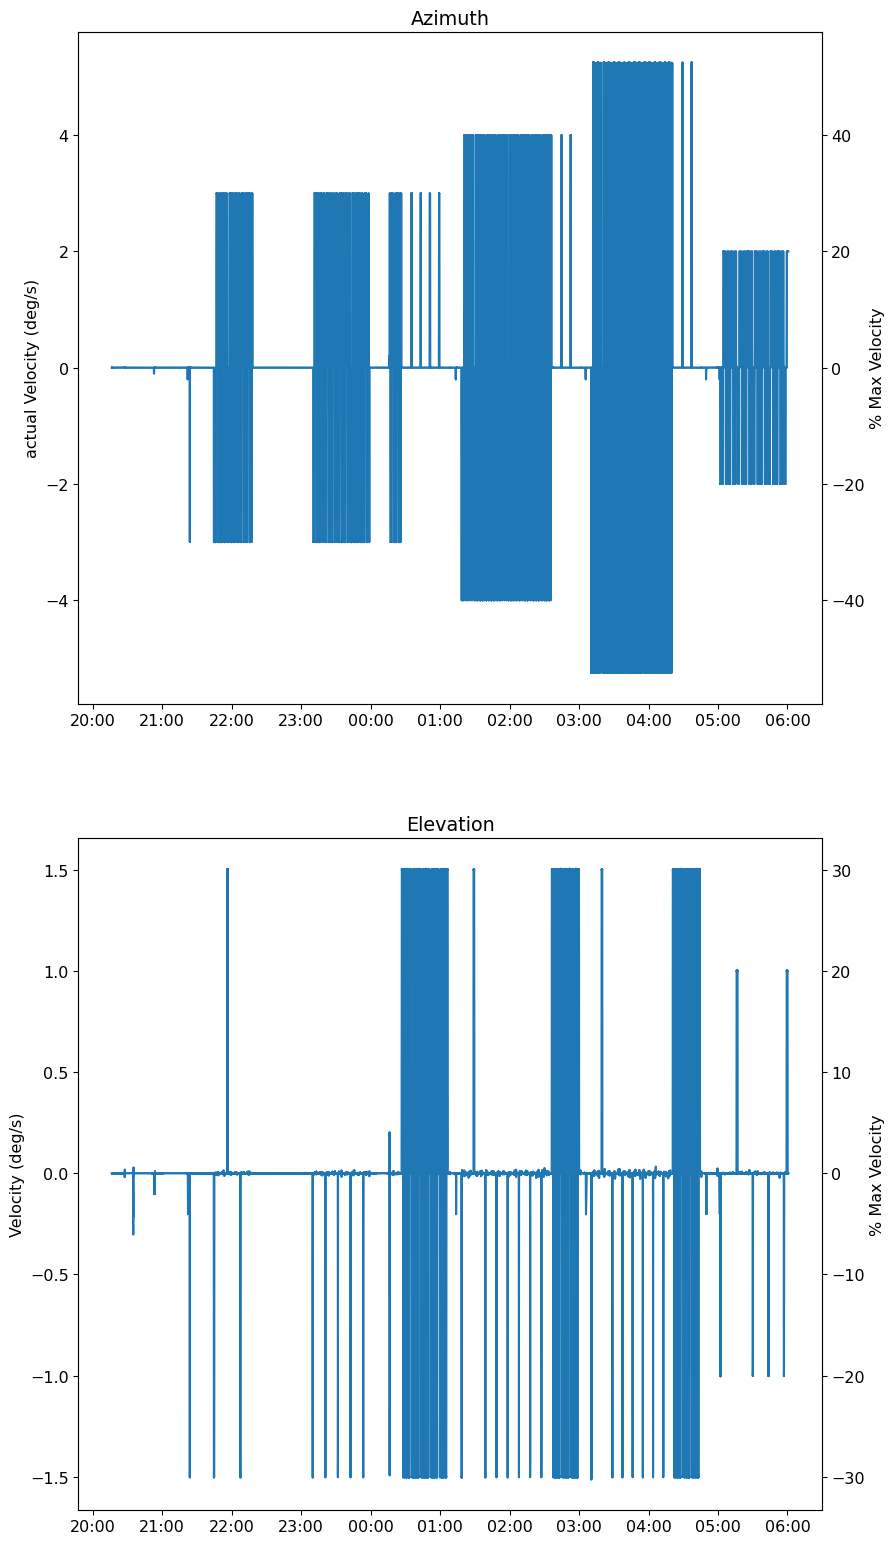

In [679]:
fig, ax = plt.subplots(2, figsize=(10, 20), dpi=96)
ax[0].plot(pd.to_datetime(az["timestamp"], unit='s', errors='coerce'),az["actualVelocity"].rolling(4).median())

#ax[0].plot(pd.to_datetime(az["timestamp"], unit='s', errors='coerce'),az["actualVelocity"])
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax2=ax[0].twinx()
ax[0].set_ylabel("actual Velocity (deg/s)")

ax2.plot(pd.to_datetime(az["timestamp"], unit='s', errors='coerce'),100.0*az["actualVelocity"].rolling(4).median()/Az_velocity_max)
ax2.set_ylabel("% Max Velocity")
ax[0].set_title('Azimuth')


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  
ax[1].plot(pd.to_datetime(el["timestamp"], unit='s', errors='coerce'),el["actualVelocity"])
ax2=ax[1].twinx()
ax2.plot(pd.to_datetime(el["timestamp"], unit='s', errors='coerce'),100.0*el["actualVelocity"]/El_velocity_max)
ax2.set_ylabel("% Max Velocity")
ax[1].set_ylabel("Velocity (deg/s)")
ax[1].set_title('Elevation')


## Identify slews 
Given a dataframe of mtMount telemetry return identified slews.
See more details about usage of vandv.mount on [link](https://github.com/lsst-sitcom/notebooks_vandv/blob/f049f63d25f4298d3b792832e63ddc6b10a589df/python/lsst/sitcom/vandv/mount.py) 

In [680]:
start_time = el['timestamp'][0] ; end_time = el['timestamp'][-1]

In [681]:
slew_select = [(slews[i].beginFloat > start_time) & (slews[i].endFloat < end_time) for i in range(len(slews))]
slew_start_select = [slews[i].beginFloat for i, x in enumerate(slew_select) if x]
slew_end_select = [slews[i].endFloat for i, x in enumerate(slew_select) if x]

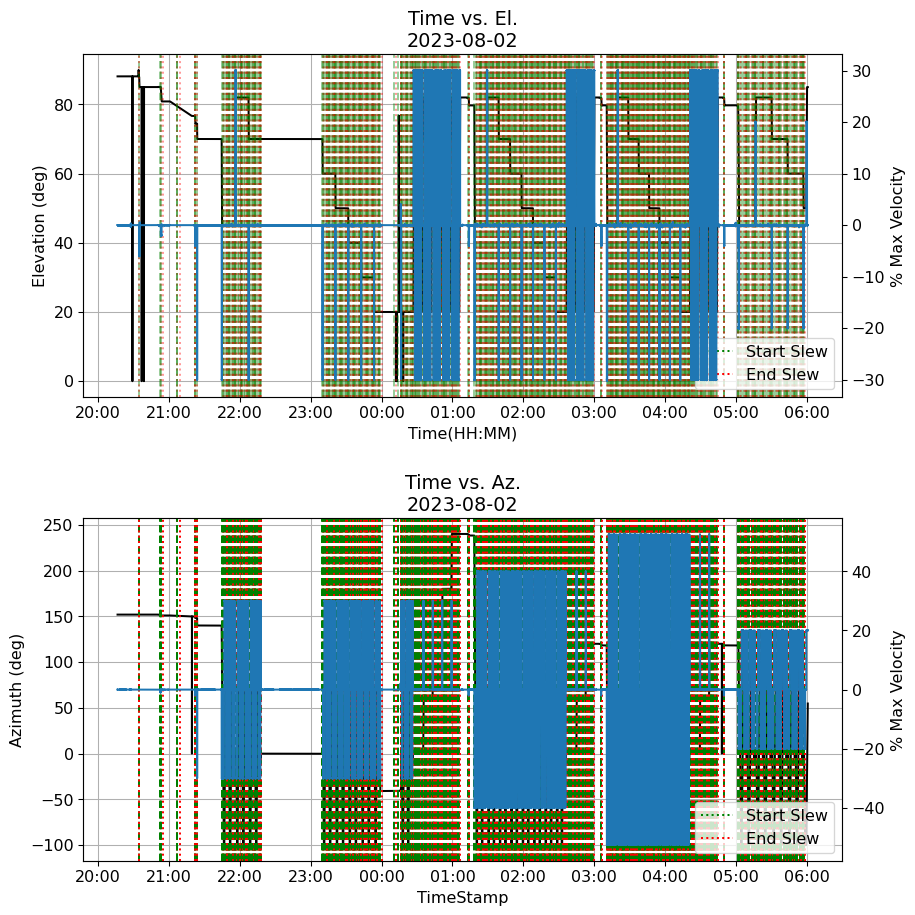

In [682]:

fig, ax = plt.subplots(2, figsize=(10, 10), dpi=96)

# Timestamp vs. Elevation
handles=[]

ax[0].plot(pd.to_datetime(el["timestamp"], unit='s', errors='coerce'),el["actualPosition"], color='black')
ax2=ax[0].twinx()
ax2.plot(pd.to_datetime(el["timestamp"], unit='s', errors='coerce'),100.0*el["actualVelocity"]/El_velocity_max)

ax[0].set_xlabel('Time(HH:MM)')
ax[0].set_ylabel('Elevation (deg)')
ax2.set_ylabel("% Max Velocity")

ax[0].set_title('Time vs. El.\n'+ str(el.index[0].strftime('%Y-%m-%d')))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  

for i in range(len(slew_start_select)):
    ax[0].axvline(pd.to_datetime(slew_start_select[i], unit='s', errors='coerce'),linestyle='--',color='green', alpha=0.4)
    ax[0].axvline(pd.to_datetime(slew_end_select[i], unit='s', errors='coerce'),linestyle=':',color='red', alpha=0.4)
    
line1 = Line2D([0], [0], label='Start Slew',linestyle=":", color='green')
line2 = Line2D([0], [0], label='End Slew', linestyle=":", color='red')

handles.extend([line1, line2])
ax[0].legend(handles=handles, loc="lower right")
ax[0].grid()


ax[1].plot(pd.to_datetime(az["timestamp"], unit='s', errors='coerce'),az["actualPosition"], color='black')
ax[1].set_xlabel('TimeStamp')
ax[1].set_ylabel('Azimuth (deg)')
ax2=ax[1].twinx()
ax2.plot(pd.to_datetime(az["timestamp"], unit='s', errors='coerce'),100.0*az["actualVelocity"]/Az_velocity_max)
ax2.set_ylabel("% Max Velocity")


for i in range(len(slew_start_select)):
    ax[1].axvline(pd.to_datetime(slew_start_select[i], unit='s', errors='coerce'),linestyle='--',color='green')
    ax[1].axvline(pd.to_datetime(slew_end_select[i], unit='s', errors='coerce'),linestyle=':',color='red')
    

ax[1].legend(handles=handles, loc="lower right")
ax[1].set_title('Time vs. Az.\n'+ str(el.index[0].strftime('%Y-%m-%d')))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  

ax[1].grid()

fig.tight_layout(pad=2.0)
plt.show()

## TMA Position and Measured Forces on Hardpoints 

Let's plot measured Forces from each hard points with Elevation or Azimuth. <br>
The maximum measured forces for each slews are represented as bars. 


### Elevation & Measured Forces w.r.t Time

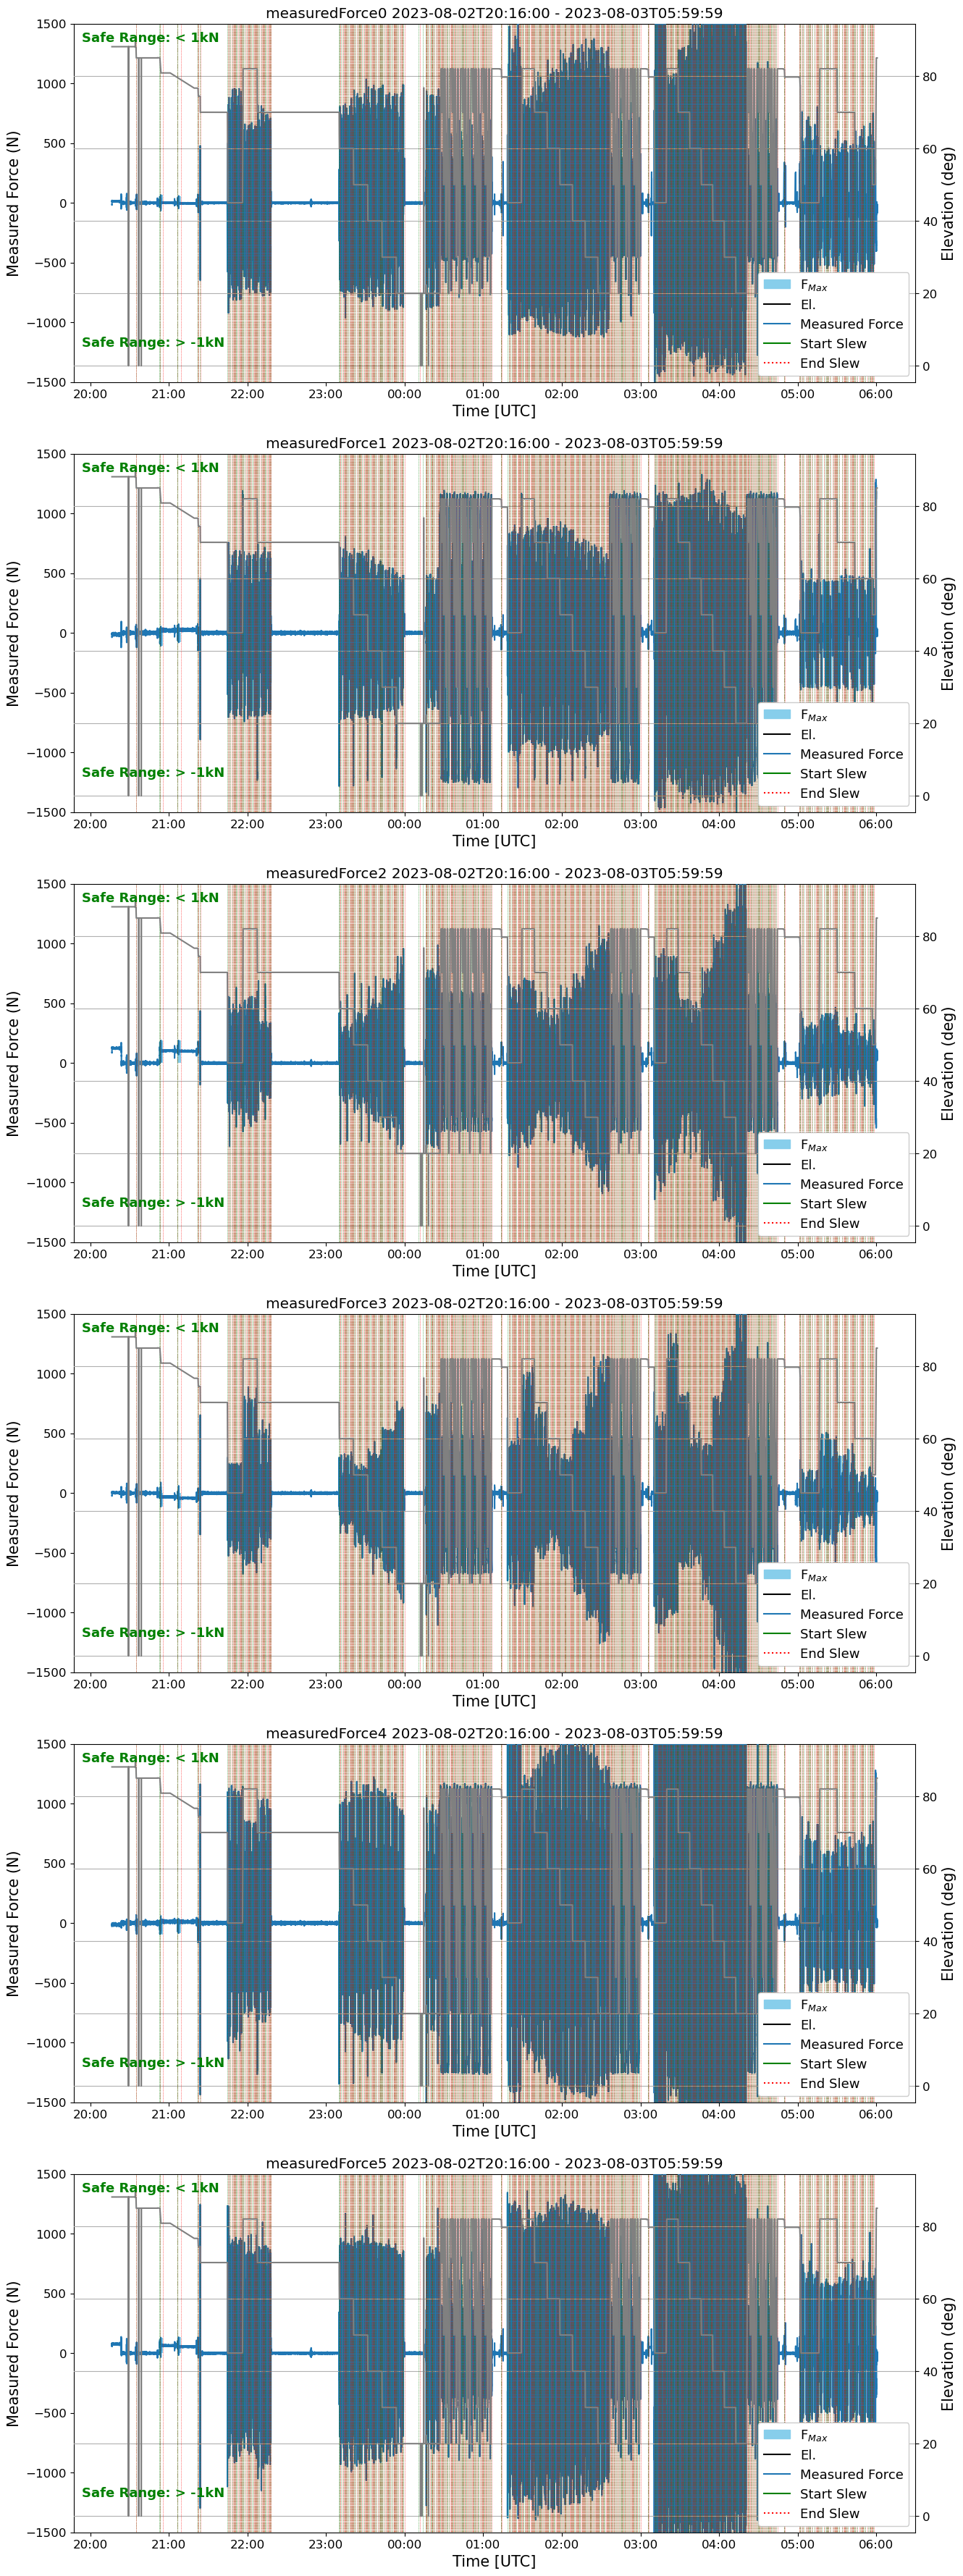

In [683]:
fig,axs = plt.subplots(6,1, figsize=(15,45))
for hp_index in range(number_of_hardpoints):
    handles=[]
    col_force = f"measuredForce{hp_index}"
    max_hardpoint_data = []
    max_hp=0
    max_el_data = [] 
    unit = 'N'
    #plt_col, plt_row = math.floor(hp_index/2), (hp_index % 2)
    plt_col = hp_index
    axs[plt_col].set_ylabel("Measured Force (N)",fontsize=15)
    axs[plt_col].set_ylim(-1500,1500)
    axs2=axs[plt_col].twinx()
    for i in range(len((slew_start_select))):
        axs2.axvline(pd.to_datetime(slew_start_select[i], unit='s', errors='coerce'),linestyle=':',color='green',linewidth=0.5)
        axs2.axvline(pd.to_datetime(slew_end_select[i], unit='s', errors='coerce'),linestyle=':',color='red',linewidth=0.5)
        handles=[] 
        pick_slew=hardpoint_data[(hardpoint_data["timestamp"]>= slew_start_select[i])&(hardpoint_data["timestamp"]<= slew_end_select[i])]
        pick_el=el[(el["timestamp"]>= slew_start_select[i])&(el["timestamp"]<= slew_end_select[i])]

        if len(pick_slew) > 0:
            if abs(max(pick_slew[col_force])) > abs(min(pick_slew[col_force])):
                max_hp = (max(pick_slew[col_force]))
            else:
                max_hp = (min(pick_slew[col_force]))    
            #max_el = pick_el[pick_slew[col_force] == max_hp]
        #axs[plt_col].bar(np.mean([slew_start_el[i],slew_end_el[i]]), max_hp, slew_end_el[i]-slew_start_el[i], color="skyblue", yerr=np.std((pick_slew[col_force])), label='Force')
        bar_start = pd.to_datetime(slew_start_select[i],unit='s', errors='coerce')
        bar_end = pd.to_datetime(slew_end_select[i],unit='s', errors='coerce')
        mean_bar = pd.to_datetime(np.mean([slew_start_select[i],slew_end_select[i]]),unit='s', errors='coerce')
        axs[plt_col].bar(mean_bar, max_hp, bar_end-bar_start, color="skyblue", label='Force')

        
    axs2.set_ylabel("Elevation (deg)",fontsize=15)
    axs[plt_col].set_xlabel("Time [UTC]", fontsize=15)
    axs2.set_title(f"measuredForce{hp_index}"+f" {el.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {el.index[-1].isoformat(timespec='seconds')[:-6]}")
    bar1= mpatches.Patch(color="skyblue",label="F$_{Max}$")
    bar2= mpatches.Patch(color="green", label="F$_{Mean}$")
    #axs[plt_col].axhspan(1000, -1000, color="lightgreen", alpha=0.05)
    axs[plt_col].axhline(2000,color='green',linewidth=1.5)
    axs[plt_col].axhline(-2000,color='green',linewidth=1.5)
    axs2.text(0.01, 0.100, 'Safe Range: > -1kN', transform=axs2.transAxes, color='g', weight="bold",fontsize=13)
    axs2.text(0.01, 0.950, 'Safe Range: < 1kN', transform=axs2.transAxes, color='g', weight="bold",fontsize=13)
    

    line1 = Line2D([0], [0], label='Start Slew', color='green')
    line2 = Line2D([0], [0], label='End Slew', linestyle=":", color='red')
    line3 = Line2D([0], [0], label='El.', color='black')
    line4 = Line2D([0], [0], label='Measured Force')


    handles.extend([bar1,line3,line4, line1, line2])
    axs2.plot(pd.to_datetime(el["timestamp"], unit='s', errors='coerce'),el["actualPosition"],color='grey')
    axs[plt_col].plot(pd.to_datetime(hardpoint_data["timestamp"], unit='s', errors='coerce'), hardpoint_data[col_force], zorder=5)
    high_values= hardpoint_data[col_force][hardpoint_data[col_force] > 300]
    high_values_time = hardpoint_data["timestamp"][hardpoint_data[col_force] > 300]

   # for i in high_values_time.values:
   #     axs[plt_col].annotate(high_values.values[i],(list(high_values_time.values[i]), high_values.values[i]))
    axs2.legend(handles=handles,fontsize=13,framealpha=1, loc='lower right')
    axs2.set_frame_on(False)
    axs2.grid()
    axs[plt_col].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  
    os.makedirs("plots/plots"+f"_{dayObs}", exist_ok=True)
    fig.savefig("plots/plots"+f"_{dayObs}"+"/El_vs_Measured_forces"+f"_{el.index[0].isoformat(timespec='seconds')[:-6]}.png")

fig.show()
            
    

### Azimuth & Measured Forces w.r.t Time

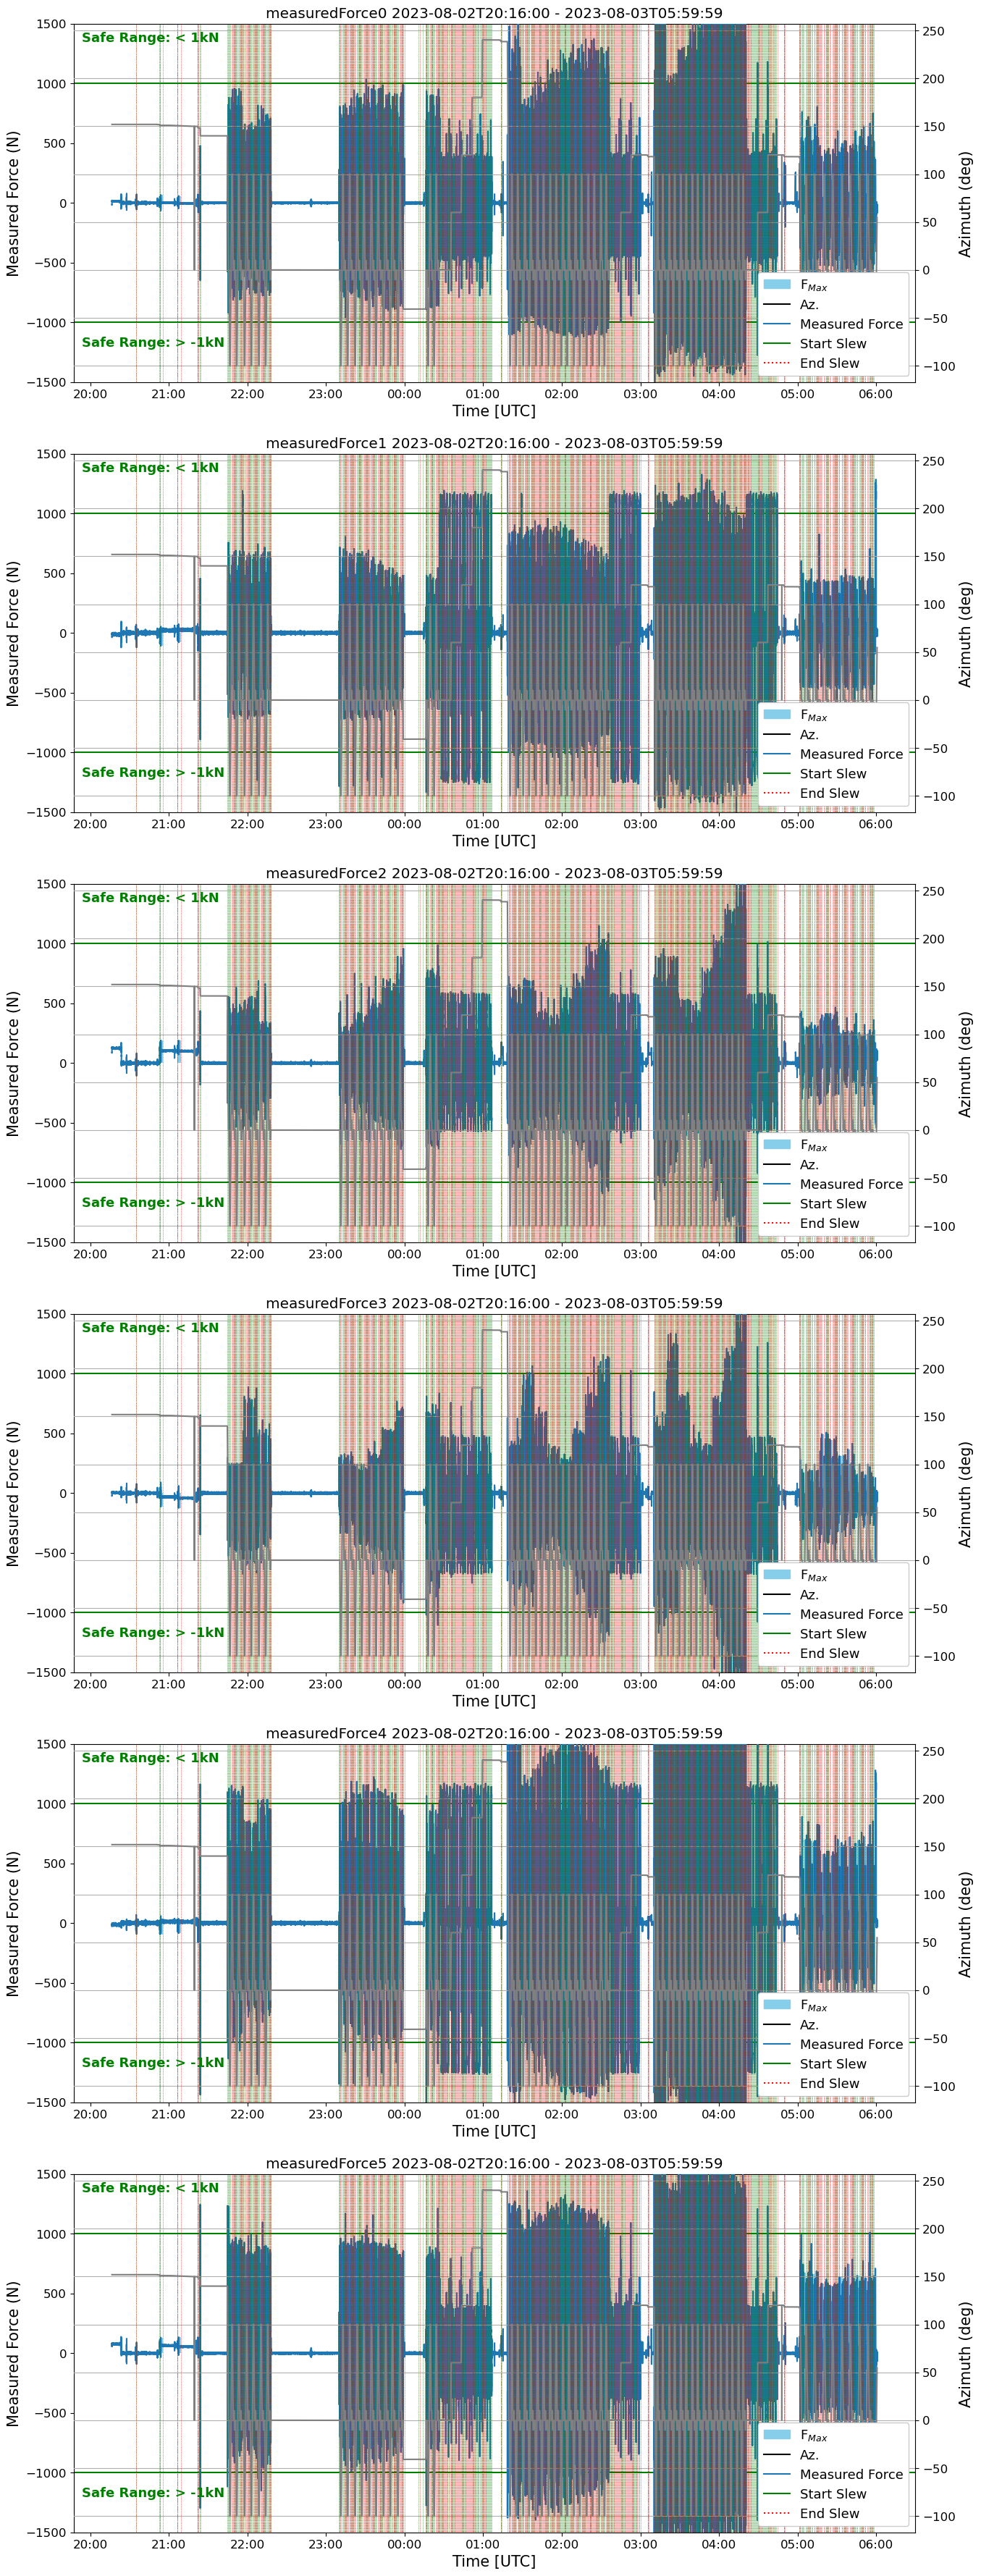

In [684]:
fig,axs = plt.subplots(6,1, figsize=(15,45))
for hp_index in range(number_of_hardpoints):
    col_force = f"measuredForce{hp_index}"
    max_hardpoint_data = []
    max_hp=0
    max_el_data = [] 
    unit = 'N'
    handles=[]
    #plt_col, plt_row = math.floor(hp_index/2), (hp_index % 2)
    plt_col = hp_index
    axs[plt_col].set_ylabel("Measured Force (N)",fontsize=15)
    axs[plt_col].set_ylim(-1500,1500)
    axs2=axs[plt_col].twinx()
    for i in range(len(slew_start_select)):
        axs2.axvline(pd.to_datetime(slew_start_select[i], unit='s', errors='coerce'),linestyle=':',color='green',linewidth=0.5)
        axs2.axvline(pd.to_datetime(slew_end_select[i], unit='s', errors='coerce'),linestyle=':',color='red',linewidth=0.5)
        handles=[] 
        pick_slew=hardpoint_data[(hardpoint_data["timestamp"]>= slew_start_select[i])&(hardpoint_data["timestamp"]<= slew_end_select[i])]
        pick_az=az[(az["timestamp"]>= slew_start_select[i])&(az["timestamp"]<= slew_end_select[i])]
        if len(pick_slew) > 0:
            if abs(max(pick_slew[col_force])) > abs(min(pick_slew[col_force])):
                max_hp = (max(pick_slew[col_force]))
            else:
                max_hp = (min(pick_slew[col_force]))    
            #max_el = pick_el[pick_slew[col_force] == max_hp]
        #axs[plt_col].bar(np.mean([slew_start_el[i],slew_end_el[i]]), max_hp, slew_end_el[i]-slew_start_el[i], color="skyblue", yerr=np.std((pick_slew[col_force])), label='Force')
        bar_start = pd.to_datetime(slew_start_select[i],unit='s', errors='coerce')
        bar_end = pd.to_datetime(slew_end_select[i],unit='s', errors='coerce')
        mean_bar = pd.to_datetime(np.mean([slew_start_select[i],slew_end_select[i]]),unit='s', errors='coerce')
        axs[plt_col].bar(mean_bar, max_hp, bar_end-bar_start, color="skyblue", label='Force')

        
    axs2.set_ylabel("Azimuth (deg)",fontsize=15)
    axs[plt_col].set_xlabel("Time [UTC]", fontsize=15)
    axs2.set_title(f"measuredForce{hp_index}"+f" {el.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {el.index[-1].isoformat(timespec='seconds')[:-6]}")
    bar1= mpatches.Patch(color="skyblue",label="F$_{Max}$")
    bar2= mpatches.Patch(color="green", label="F$_{Mean}$")
    #axs[plt_col].axhspan(1000, -1000, color="lightgreen", alpha=0.05)
    axs[plt_col].axhline(1000,color='green',linewidth=1.5)
    axs[plt_col].axhline(-1000,color='green',linewidth=1.5)
    axs2.text(0.01, 0.100, 'Safe Range: > -1kN', transform=axs2.transAxes, color='g', weight="bold",fontsize=13)
    axs2.text(0.01, 0.950, 'Safe Range: < 1kN', transform=axs2.transAxes, color='g', weight="bold",fontsize=13)
    

    line1 = Line2D([0], [0], label='Start Slew', color='green')
    line2 = Line2D([0], [0], label='End Slew', linestyle=":", color='red')
    line3 = Line2D([0], [0], label='Az.', color='black')
    line4 = Line2D([0], [0], label='Measured Force')


    handles.extend([bar1,line3,line4, line1, line2])
    axs2.plot(pd.to_datetime(az["timestamp"], unit='s', errors='coerce'),az["actualPosition"],color='grey')
    axs[plt_col].plot(pd.to_datetime(hardpoint_data["timestamp"], unit='s', errors='coerce'), hardpoint_data[col_force], zorder=5)
    high_values= hardpoint_data[col_force][hardpoint_data[col_force] > 300]
    high_values_time = hardpoint_data["timestamp"][hardpoint_data[col_force] > 300]

   # for i in high_values_time.values:
   #     axs[plt_col].annotate(high_values.values[i],(list(high_values_time.values[i]), high_values.values[i]))
    axs2.legend(handles=handles,fontsize=13,framealpha=1,loc="lower right")
    axs2.set_frame_on(False)
    axs2.grid()
    axs[plt_col].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  
    os.makedirs("plots/plots"+f"_{dayObs}", exist_ok=True)
    fig.savefig(f"plots/plots"+f"_{dayObs}"+"/Az_vs_Measured_forces"+f"_{el.index[0].isoformat(timespec='seconds')[:-6]}.png")

fig.show()
            
    

## Histograms of Maximum Measured Forces
Now we will plot histograms of Maximum Measured Forces for each Hardpoint.<br>
If the absolute values of the maximum do not exceed the +-1kN during the slew, it is within the safe range. 

### Histogram for Maximum Measured Forces (Slewing in Elevation direction)

In [685]:
#all values are percentiles of the max. slewing speed. 
slew_speed = [1, 5, 10, 20, 30, 35, 40, 50, 60, 70, 80, 90, 100] 

In [686]:
slew_speed_Az = [i * Az_velocity_max / 100 for i in slew_speed]
slew_speed_El = [i * El_velocity_max / 100 for i in slew_speed]

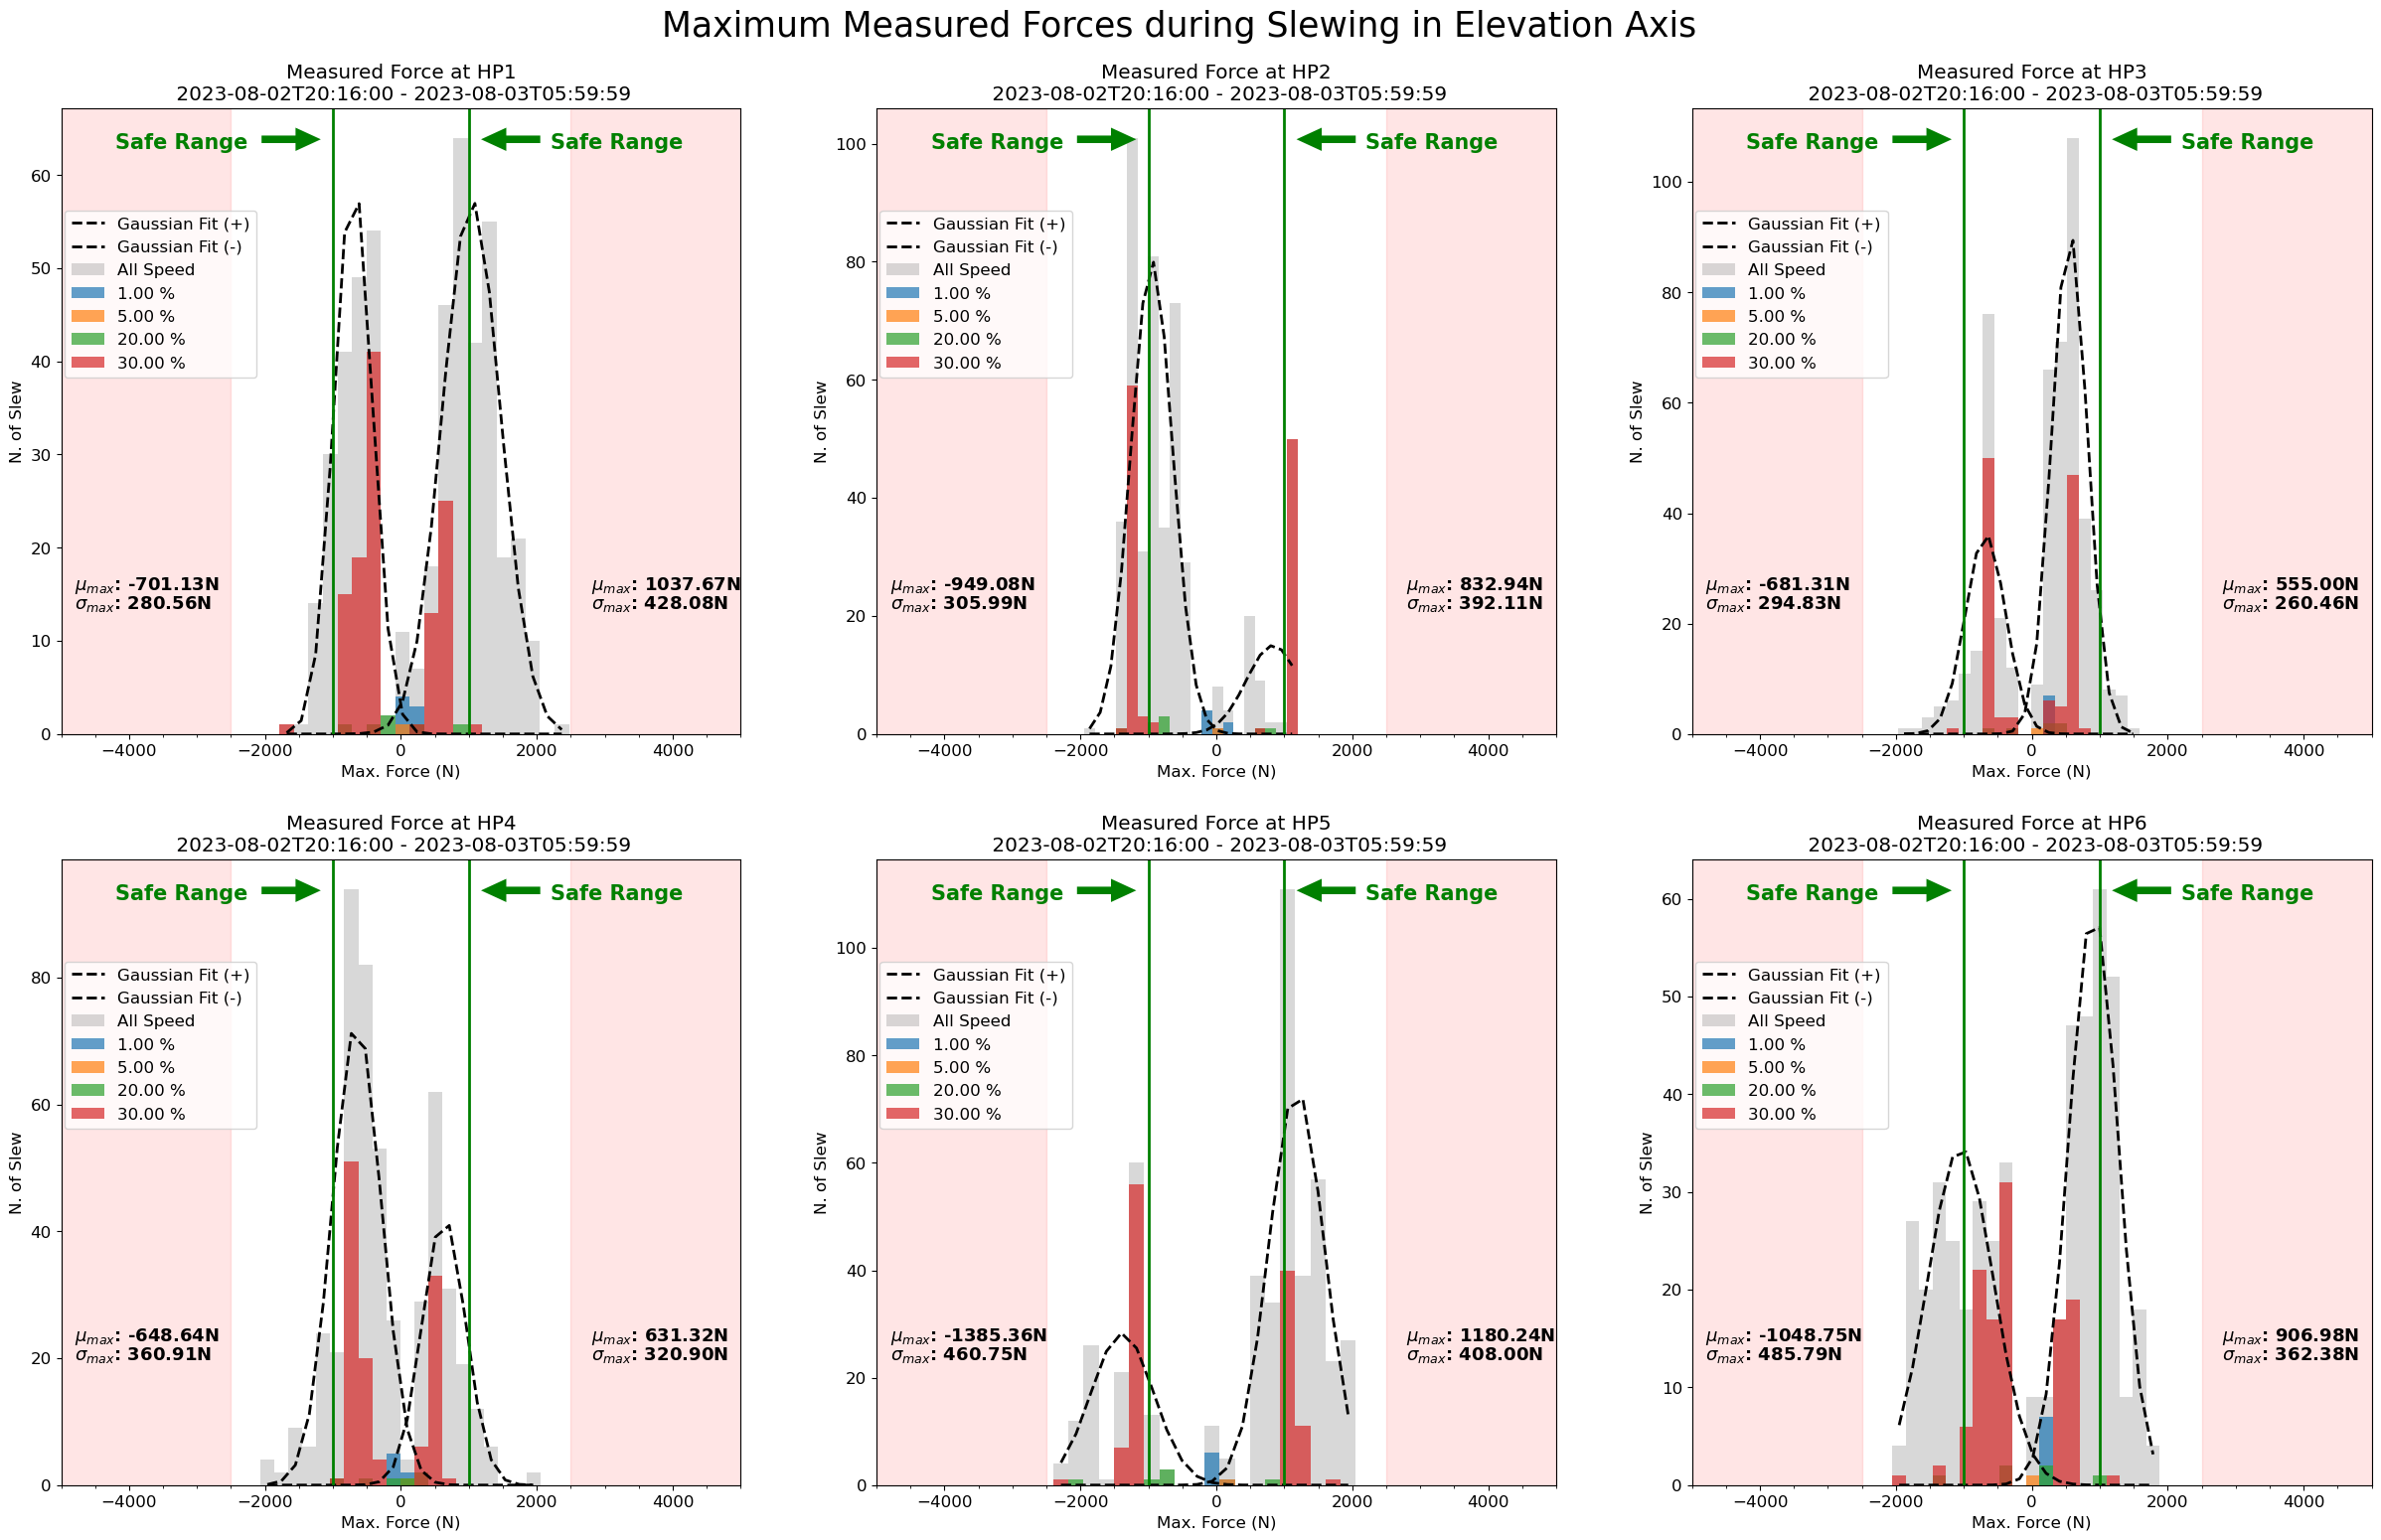

In [687]:
#Histograms of Maximum Measured Forces for slewing in Elevation. 

fig,axs = plt.subplots(2,3, figsize=(30,18))
for hp_index in range(number_of_hardpoints):
    col_force = f"measuredForce{hp_index}"
    col_encoder = f"encoder{hp_index}"
    max_hardpoint_data = []
    min_hardpoint_data = []
    velocity_el = []
    handles=[]
    plt_col, plt_row = math.floor(hp_index/3), (hp_index % 3) 
    unit = 'N'
    axs[plt_col,plt_row].set_title(f"Measured Force at HP{hp_index+1}\n"
             f" {el.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {el.index[-1].isoformat(timespec='seconds')[:-6]}")
    axs[plt_col,plt_row].set_xlabel('Max. Force (N)')
    axs[plt_col,plt_row].set_ylabel('N. of Slew')
    axs[plt_col,plt_row].axvspan(-5000, -2500, color='r',alpha=0.1)
    axs[plt_col,plt_row].axvspan(2500, 5000, color='r',alpha=0.1)

    #Velocity and maximum HP measured forces  
    for i in range(len(slew_start_select)):
        pick_slew=hardpoint_data[(hardpoint_data["timestamp"]>= slew_start_select[i])&(hardpoint_data["timestamp"]<= slew_end_select[i])]
        
        if len(pick_slew) > 1: 
            pick_el=el[(el["timestamp"]>= slew_start_select[i])&(el["timestamp"]<= slew_end_select[i])]
            if len(pick_el["actualVelocity"]) > 0: 
                velocity_el.append(max(abs(pick_el["actualVelocity"])))
                if abs(max(pick_slew[col_force])) > abs(min(pick_slew[col_force])):
                    max_hardpoint_data.append(max(pick_slew[col_force]))
                else:
                    max_hardpoint_data.append(min(pick_slew[col_force])) 
                    
        
    #Draw Histogram
    n, bins, patches = axs[plt_col, plt_row].hist((max_hardpoint_data), 20, alpha=0.0, color="white")

    bin_heights, bin_edges = np.histogram((max_hardpoint_data), 20, density=1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mu, sigma = norm.fit(max_hardpoint_data)
    gaussian_values = norm.pdf(bin_centers, mu, sigma)
    
    max_hardpoint_data_up = [max_hardpoint_data[i] for i in range(len(max_hardpoint_data))\
                             if max_hardpoint_data[i] >=0]
    
    max_hardpoint_data_down = [max_hardpoint_data[i] for i in range(len(max_hardpoint_data))\
                             if max_hardpoint_data[i] < 0]
    

    
    mu_up, sigma_up = norm.fit(max_hardpoint_data_up)
    mu_down, sigma_down = norm.fit(max_hardpoint_data_down)

    gaussian_values_up = norm.pdf(bin_centers, mu_up, sigma_up)
    gaussian_values_down = norm.pdf(bin_centers, mu_down, sigma_down)

    
    #axs[plt_col, plt_row].plot(bin_centers, gaussian_values*len(max_hardpoint_data)*[bins[1]-bins[0]], 'r--', label='Gaussian Fit')
    axs[plt_col, plt_row].plot(bin_centers, gaussian_values_up*len(max_hardpoint_data_up)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (+)', linewidth=2)
    axs[plt_col, plt_row].plot(bin_centers, gaussian_values_down*len(max_hardpoint_data_down)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (-)', linewidth=2)
    n, bins, patches = axs[plt_col, plt_row].hist((max_hardpoint_data), 20, alpha=0.3, color="gray", label="All Speed")

    
    axs[plt_col,plt_row].axvline(1000,color='green',linewidth=2)
    axs[plt_col,plt_row].axvline(-1000,color='green',linewidth=2)
    axs[plt_col,plt_row].text(0.08, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold", fontsize=15)
    axs[plt_col,plt_row].text(0.72, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold",fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.900, 'Elevation', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.850, 'vs. F$_{HP}$', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)

    #mark different velocities
        
    for i_vel_select in range(1, len(slew_speed_El)):
        vel_hp_data = [max_hardpoint_data[i] for i in range(len(max_hardpoint_data))\
                       if velocity_el[i] >= slew_speed_El[i_vel_select-1] and \
                       velocity_el[i] < slew_speed_El[i_vel_select]]
        
        if len(vel_hp_data) > 0:                 
            axs[plt_col, plt_row].hist((vel_hp_data), bins=bins, alpha=0.7, label="{:.2f}".format(100.0*slew_speed_El[i_vel_select-1]/El_velocity_max)+" %")

    
    #axs[plt_col, plt_row].axvspan(1000, -1000, color="lightgreen", alpha=0.05)

    axs[plt_col,plt_row].set_xlim(-5000,5000)
    arrow_style = {"head_width":0.02, "head_length":0.02, "color":"g", "linewidth":5, "transform":axs[plt_col,plt_row].transAxes}
    axs[plt_col,plt_row].arrow(x=0.3, y=0.95, dx=0.05, dy=0, **arrow_style)
    axs[plt_col,plt_row].arrow(x=0.7, y=0.95, dx=-0.05, dy=0, **arrow_style)

    
    axs[plt_col,plt_row].text(0.02,0.2, "${\sigma}_{max}$: "+"{:6.2f}".format(sigma_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.02,0.23, "${\mu}_{max}$: "+"{:6.2f}".format(mu_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.2, "${\sigma}_{max}$: "+"{:6.2f}".format(sigma_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.23, "${\mu}_{max}$: "+"{:6.2f}".format(mu_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    #axs[plt_col,plt_row].text(0.7,0.85, "${std.dev}_{max}$:"+"{:6.2f}".format(np.std(np.absolute(max_hardpoint_data)))+" N", transform=axs[plt_col,plt_row].transAxes, weight="bold")
    axs[plt_col,plt_row].yaxis.get_major_locator().set_params(integer=True)
    
    #axs[0, 2].legend(bbox_to_anchor=(1.4,1))
    #axs[plt_col,plt_row].legend(bbox_to_anchor=(0.325,0.85))
    axs[plt_col,plt_row].legend(bbox_to_anchor=(0.3,0.85))

    axs[plt_col,plt_row].xaxis.set_minor_locator(MultipleLocator(500))


os.makedirs("plots/plots"+f"_{dayObs}", exist_ok=True)
fig.suptitle("Maximum Measured Forces during Slewing in Elevation Axis",fontsize=25, y=0.935)
fig.savefig("plots/plots"+f"_{dayObs}"+"/Measured_Force_data_all_el_max"+f"_{el.index[0].isoformat(timespec='seconds')[:-6]}.png")
fig.show()

#timestamp = hardpoint_data.index[0].isoformat().split('.')[0].replace('-','').replace(':','')


### Histogram for Maximum Measured Forces (Slewing in Azimuth direction)

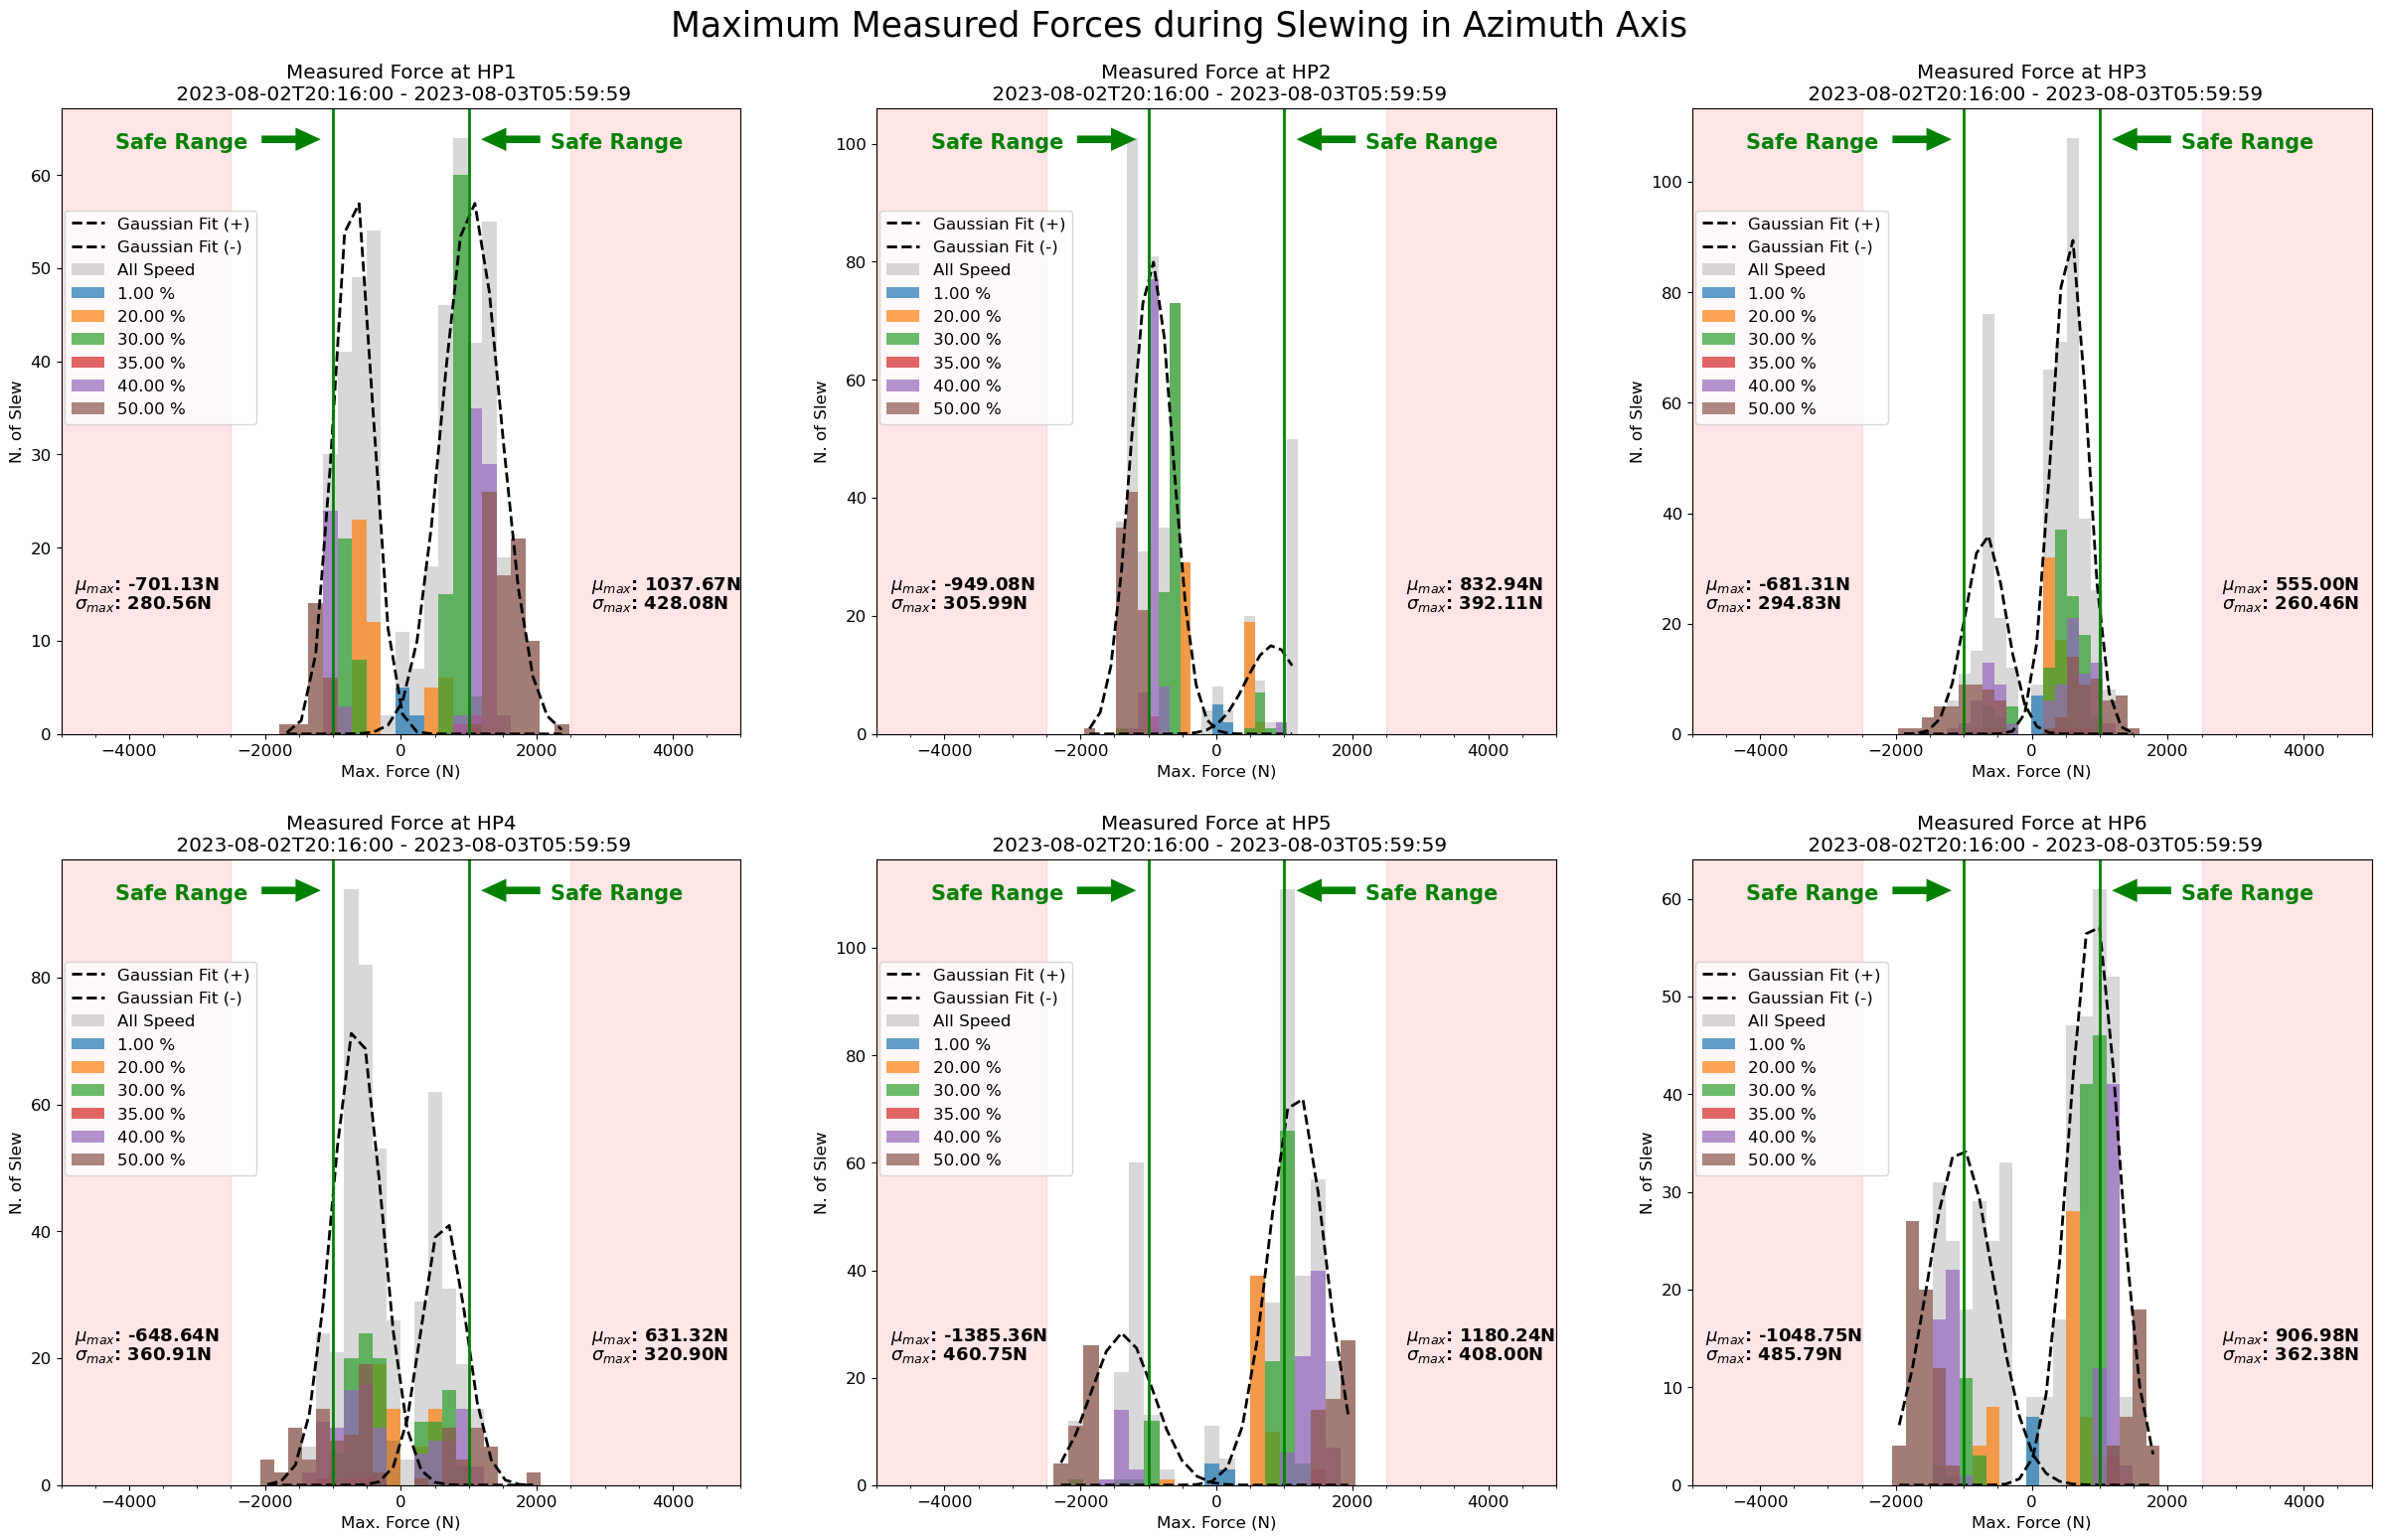

In [688]:
#Histograms of Maximum Measured Forces for slewing in Azimuth direction

fig,axs = plt.subplots(2,3, figsize=(30,18))
for hp_index in range(number_of_hardpoints):
    col_force = f"measuredForce{hp_index}"
    col_encoder = f"encoder{hp_index}"
    max_hardpoint_data = []
    min_hardpoint_data = []
    velocity_az = []
    handles=[]
    plt_col, plt_row = math.floor(hp_index/3), (hp_index % 3) 
    unit = 'N'
    axs[plt_col,plt_row].set_title(f"Measured Force at HP{hp_index+1}\n"
             f" {el.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {el.index[-1].isoformat(timespec='seconds')[:-6]}")
    axs[plt_col,plt_row].set_xlabel('Max. Force (N)')
    axs[plt_col,plt_row].set_ylabel('N. of Slew')
    axs[plt_col,plt_row].axvspan(-5000, -2500, color='r',alpha=0.1)
    axs[plt_col,plt_row].axvspan(2500, 5000, color='r',alpha=0.1)

    #Velocity and maximum HP measured forces  
    for i in range(len(slew_start_select)):
        pick_slew=hardpoint_data[(hardpoint_data["timestamp"]>= slew_start_select[i])&(hardpoint_data["timestamp"]<= slew_end_select[i])]
        
        if len(pick_slew) > 10: 
            pick_az=az[(az["timestamp"]>= slew_start_select[i])&(az["timestamp"]<= slew_end_select[i])]
            if len(pick_az["actualVelocity"]) > 0: 
                velocity_az.append(max(abs(pick_az["actualVelocity"])))
                if abs(max(pick_slew[col_force])) > abs(min(pick_slew[col_force])):
                    max_hardpoint_data.append(max(pick_slew[col_force]))
                else:
                    max_hardpoint_data.append(min(pick_slew[col_force])) 
                    
        
    #Draw Histogram
    n, bins, patches = axs[plt_col, plt_row].hist((max_hardpoint_data), 20, alpha=0.0, color="white")

    bin_heights, bin_edges = np.histogram((max_hardpoint_data), 20, density=1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mu, sigma = norm.fit(max_hardpoint_data)
    gaussian_values = norm.pdf(bin_centers, mu, sigma)
    
    max_hardpoint_data_up = [max_hardpoint_data[i] for i in range(len(max_hardpoint_data))\
                             if max_hardpoint_data[i] >=0]
    
    max_hardpoint_data_down = [max_hardpoint_data[i] for i in range(len(max_hardpoint_data))\
                             if max_hardpoint_data[i] < 0]
    

    
    mu_up, sigma_up = norm.fit(max_hardpoint_data_up)
    mu_down, sigma_down = norm.fit(max_hardpoint_data_down)

    gaussian_values_up = norm.pdf(bin_centers, mu_up, sigma_up)
    gaussian_values_down = norm.pdf(bin_centers, mu_down, sigma_down)

    
    #axs[plt_col, plt_row].plot(bin_centers, gaussian_values*len(max_hardpoint_data)*[bins[1]-bins[0]], 'r--', label='Gaussian Fit')
    axs[plt_col, plt_row].plot(bin_centers, gaussian_values_up*len(max_hardpoint_data_up)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (+)', linewidth=2)
    axs[plt_col, plt_row].plot(bin_centers, gaussian_values_down*len(max_hardpoint_data_down)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (-)', linewidth=2)
    n, bins, patches = axs[plt_col, plt_row].hist((max_hardpoint_data), 20, alpha=0.3, color="gray", label="All Speed")

    
    axs[plt_col,plt_row].axvline(1000,color='green',linewidth=2)
    axs[plt_col,plt_row].axvline(-1000,color='green',linewidth=2)
    axs[plt_col,plt_row].text(0.08, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold", fontsize=15)
    axs[plt_col,plt_row].text(0.72, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold",fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.900, 'Elevation', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.850, 'vs. F$_{HP}$', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)

    #mark different velocities
        
    for i_vel_select in range(1, len(slew_speed_Az
                                    
                                    )):
        vel_hp_data = [max_hardpoint_data[i] for i in range(len(max_hardpoint_data))\
                       if velocity_az[i] >= slew_speed_Az[i_vel_select-1] and \
                       velocity_az[i] < slew_speed_Az[i_vel_select]]
        
        if len(vel_hp_data) > 0:                 
            axs[plt_col, plt_row].hist((vel_hp_data), bins=bins, alpha=0.7, label="{:.2f}".format(100.0*slew_speed_Az[i_vel_select-1]/Az_velocity_max)+" %")

    
    #axs[plt_col, plt_row].axvspan(1000, -1000, color="lightgreen", alpha=0.05)

    axs[plt_col,plt_row].set_xlim(-5000,5000)
    arrow_style = {"head_width":0.02, "head_length":0.02, "color":"g", "linewidth":5, "transform":axs[plt_col,plt_row].transAxes}
    axs[plt_col,plt_row].arrow(x=0.3, y=0.95, dx=0.05, dy=0, **arrow_style)
    axs[plt_col,plt_row].arrow(x=0.7, y=0.95, dx=-0.05, dy=0, **arrow_style)

    
    axs[plt_col,plt_row].text(0.02,0.2, "${\sigma}_{max}$: "+"{:6.2f}".format(sigma_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.02,0.23, "${\mu}_{max}$: "+"{:6.2f}".format(mu_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.2, "${\sigma}_{max}$: "+"{:6.2f}".format(sigma_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.23, "${\mu}_{max}$: "+"{:6.2f}".format(mu_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    #axs[plt_col,plt_row].text(0.7,0.85, "${std.dev}_{max}$:"+"{:6.2f}".format(np.std(np.absolute(max_hardpoint_data)))+" N", transform=axs[plt_col,plt_row].transAxes, weight="bold")
    axs[plt_col,plt_row].yaxis.get_major_locator().set_params(integer=True)
    
    #axs[0, 2].legend(bbox_to_anchor=(1.4,1))
    #axs[plt_col,plt_row].legend(bbox_to_anchor=(0.325,0.85))
    axs[plt_col,plt_row].legend(bbox_to_anchor=(0.3,0.85))

    axs[plt_col,plt_row].xaxis.set_minor_locator(MultipleLocator(500))


os.makedirs("plots/plots"+f"_{dayObs}", exist_ok=True)
fig.suptitle("Maximum Measured Forces during Slewing in Azimuth Axis",fontsize=25, y=0.935)
fig.savefig("plots/plots"+f"_{dayObs}"+"/Measured_Force_data_all_az_max"+f"_{az.index[0].isoformat(timespec='seconds')[:-6]}.png")
fig.show()

#timestamp = hardpoint_data.index[0].isoformat().split('.')[0].replace('-','').replace(':','')


### Histogram for Mean Measured Forces (Slewing in Elevation direction)


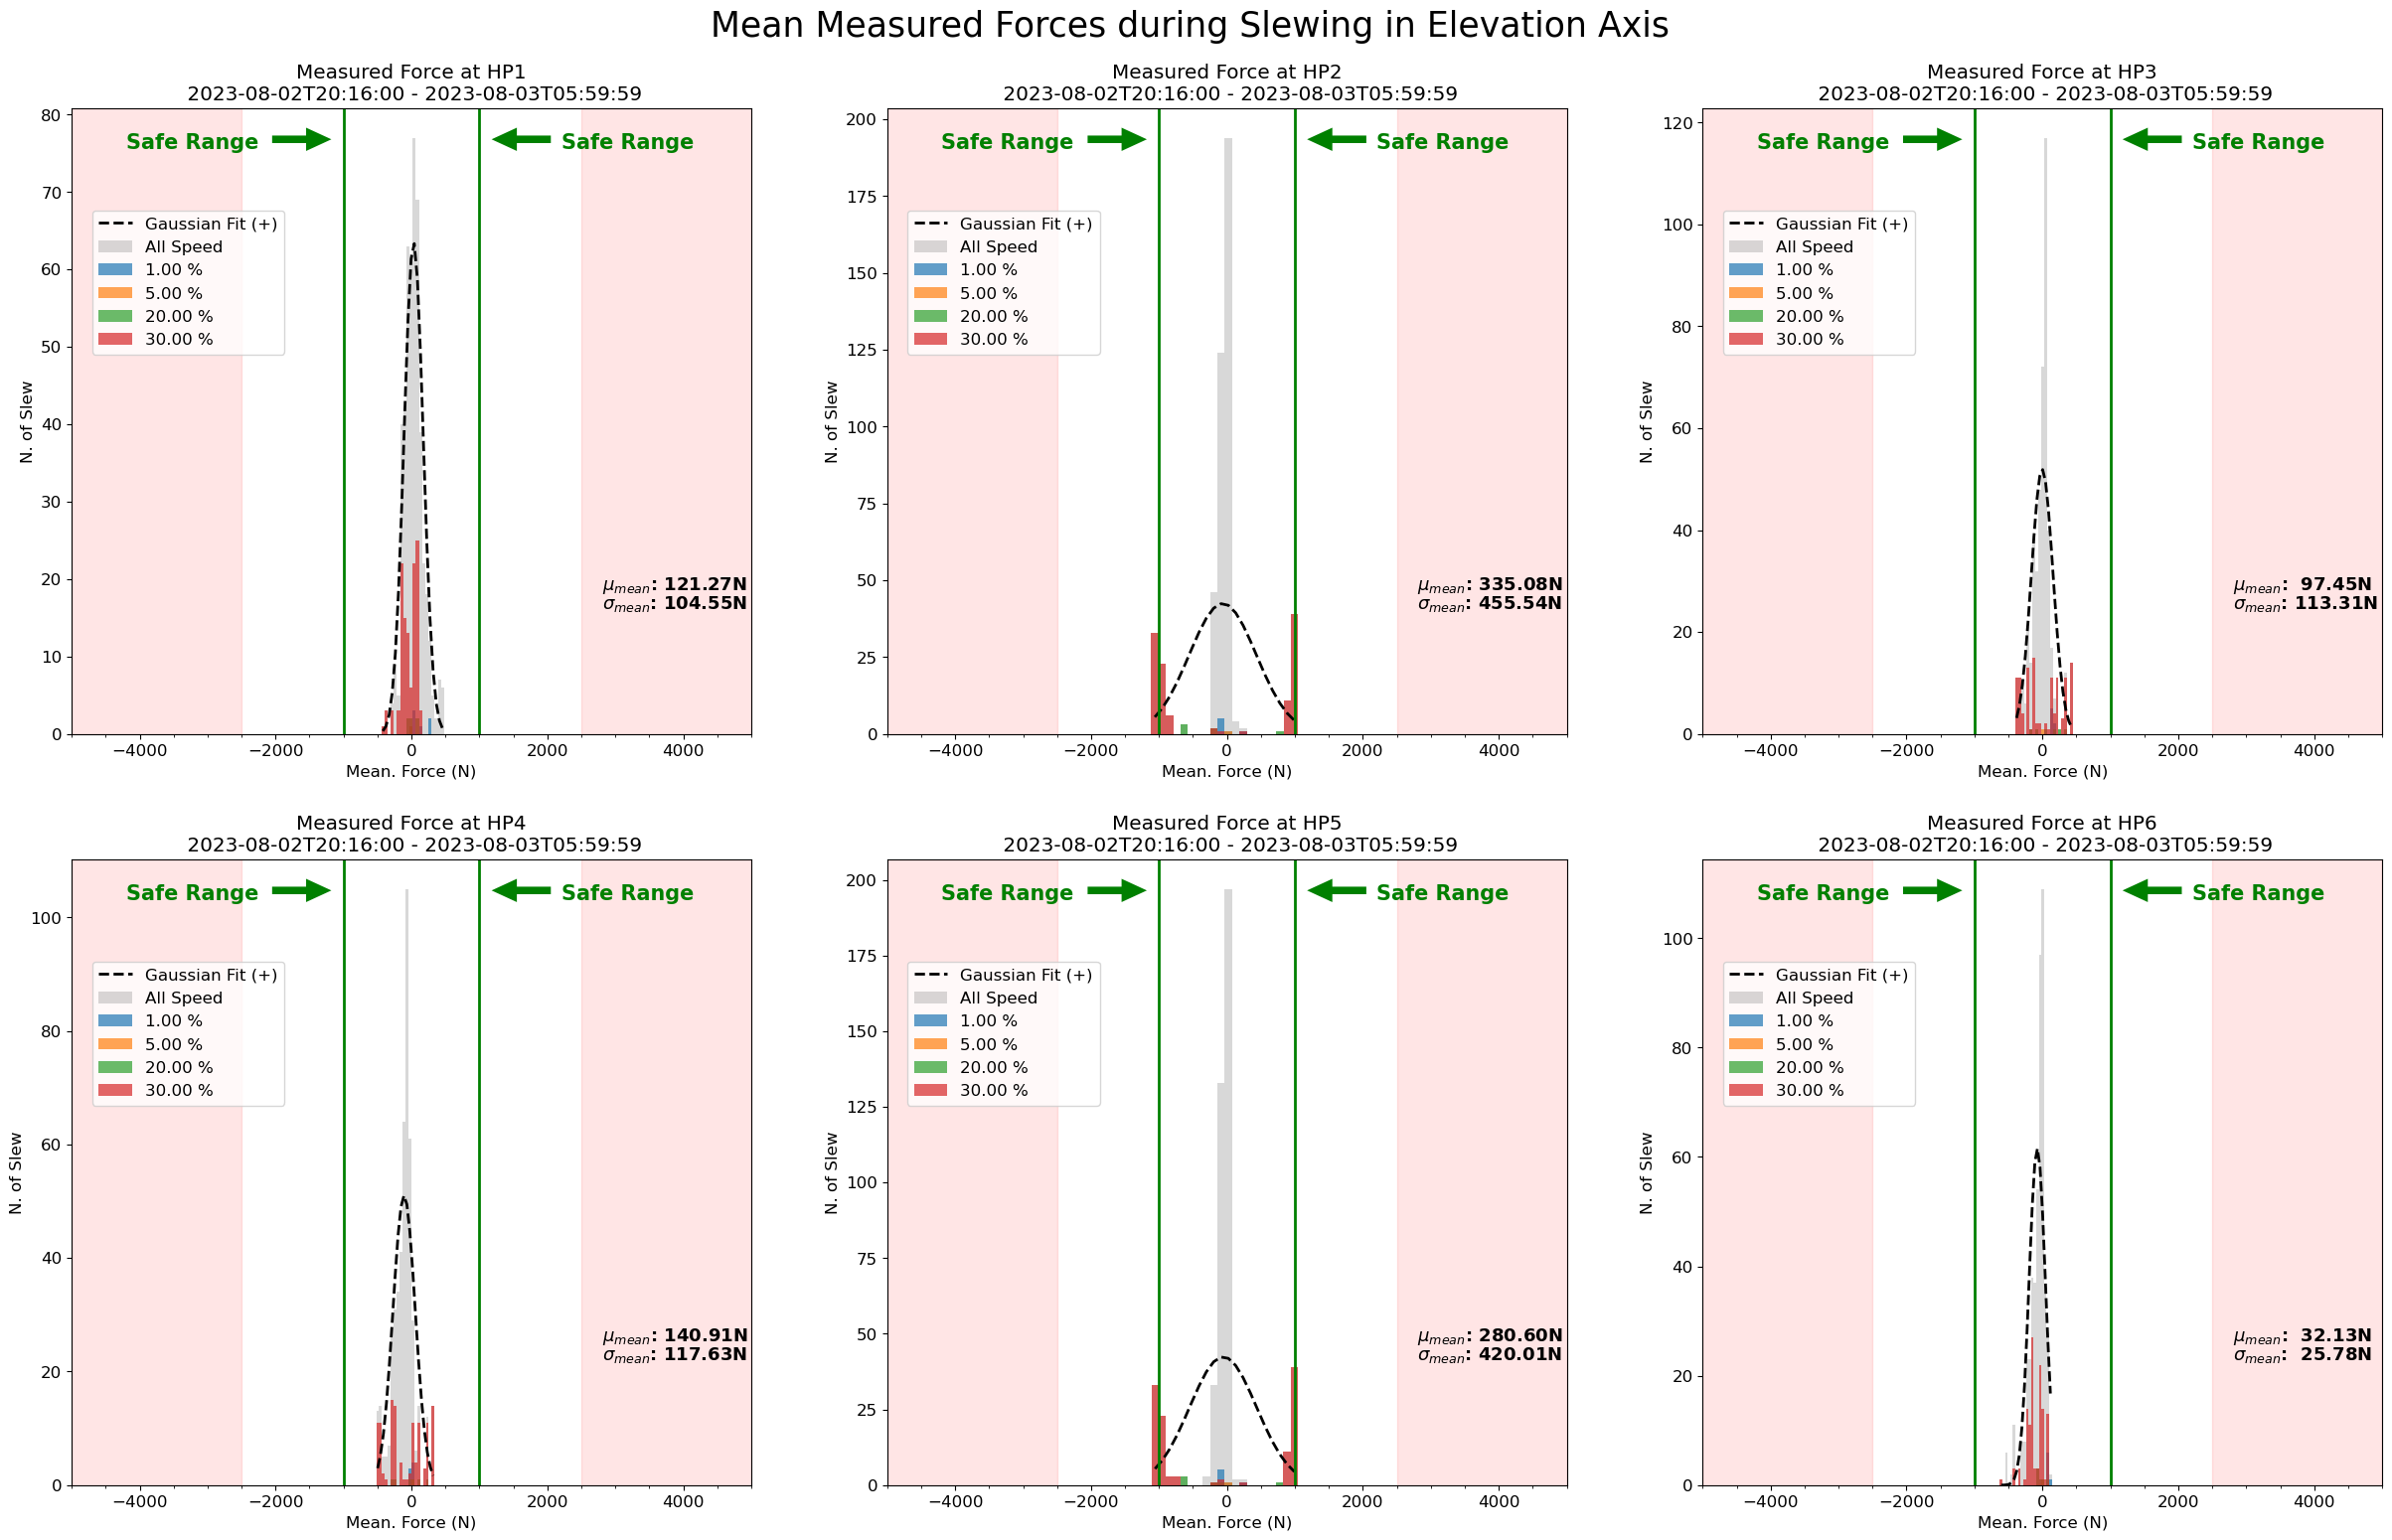

In [689]:
#Histograms of Mean Measured Forces for slewing in Elevation

fig,axs = plt.subplots(2,3, figsize=(30,18))
for hp_index in range(number_of_hardpoints):
    col_force = f"measuredForce{hp_index}"
    col_encoder = f"encoder{hp_index}"
    mean_hardpoint_data = []
    velocity_ = []
    handles=[]
    plt_col, plt_row = math.floor(hp_index/3), (hp_index % 3) 
    unit = 'N'
    axs[plt_col,plt_row].set_title(f"Measured Force at HP{hp_index+1}\n"
             f" {az.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {az.index[-1].isoformat(timespec='seconds')[:-6]}")
    axs[plt_col,plt_row].set_xlabel('Mean. Force (N)')
    axs[plt_col,plt_row].set_ylabel('N. of Slew')
    axs[plt_col,plt_row].axvspan(-5000, -2500, color='r',alpha=0.1)
    axs[plt_col,plt_row].axvspan(2500, 5000, color='r',alpha=0.1)
      
    #Velocity and mean HP measured forces  
    for i in range(len(slew_start_select)):
        pick_slew=hardpoint_data[(hardpoint_data["timestamp"]>= slew_start_select[i])&(hardpoint_data["timestamp"]<= slew_end_select[i])] 
        
        if len(pick_slew) > 1: 
            pick_el=el[(el["timestamp"]>= slew_start_select[i])&(el["timestamp"]<= slew_end_select[i])]
            
            if len(pick_el) > 1: 
                velocity_el.append(max(abs(pick_el["actualVelocity"])))
                mean_hardpoint_data.append(np.mean(pick_slew[col_force]))       
        
                    
        
    #Draw Histogram
    n, bins, patches = axs[plt_col, plt_row].hist((mean_hardpoint_data), 20, alpha=0.0, color="white")

    bin_heights, bin_edges = np.histogram((mean_hardpoint_data), 20, density=1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mu, sigma = norm.fit(mean_hardpoint_data)
    gaussian_values = norm.pdf(bin_centers, mu, sigma)
    
    mean_hardpoint_data_up = [mean_hardpoint_data[i] for i in range(len(mean_hardpoint_data))\
                             if mean_hardpoint_data[i] >=0]
    
    mean_hardpoint_data_down = [mean_hardpoint_data[i] for i in range(len(mean_hardpoint_data))\
                             if mean_hardpoint_data[i] < 0]
    

    
    mu_up, sigma_up = norm.fit(mean_hardpoint_data_up)
    mu_down, sigma_down = norm.fit(mean_hardpoint_data_down)

    gaussian_values_up = norm.pdf(bin_centers, mu_up, sigma_up)
    gaussian_values_down = norm.pdf(bin_centers, mu_down, sigma_down)

    
    #axs[plt_col, plt_row].plot(bin_centers, gaussian_values*len(mean_hardpoint_data)*[bins[1]-bins[0]], 'r--', label='Gaussian Fit')
    axs[plt_col, plt_row].plot(bin_centers, gaussian_values*len(mean_hardpoint_data)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (+)', linewidth=2)
    #axs[plt_col, plt_row].plot(bin_centers, gaussian_values_down*len(mean_hardpoint_data_down)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (-)', linewidth=2)
    n, bins, patches = axs[plt_col, plt_row].hist((mean_hardpoint_data), 20, alpha=0.3, color="gray", label="All Speed")

    
    axs[plt_col,plt_row].axvline(1000,color='green',linewidth=2)
    axs[plt_col,plt_row].axvline(-1000,color='green',linewidth=2)
    axs[plt_col,plt_row].text(0.08, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold", fontsize=15)
    axs[plt_col,plt_row].text(0.72, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold",fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.900, 'Elevation', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.850, 'vs. F$_{HP}$', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)

    #mark different velocities
        
    for i_vel_select in range(1, len(slew_speed_El)):
        vel_hp_data = [mean_hardpoint_data[i] for i in range(len(mean_hardpoint_data))\
                       if velocity_el[i] >= slew_speed_El[i_vel_select-1] and \
                       velocity_el[i] < slew_speed_El[i_vel_select]]
        
        if len(vel_hp_data) > 0:                 
            axs[plt_col, plt_row].hist((vel_hp_data), bins=bins, alpha=0.7, label="{:.2f}".format(100.0*slew_speed_El[i_vel_select-1]/El_velocity_max)+" %")

    
    #axs[plt_col, plt_row].axvspan(1000, -1000, color="lightgreen", alpha=0.05)

    axs[plt_col,plt_row].set_xlim(-5000,5000)
    arrow_style = {"head_width":0.02, "head_length":0.02, "color":"g", "linewidth":5, "transform":axs[plt_col,plt_row].transAxes}
    axs[plt_col,plt_row].arrow(x=0.3, y=0.95, dx=0.05, dy=0, **arrow_style)
    axs[plt_col,plt_row].arrow(x=0.7, y=0.95, dx=-0.05, dy=0, **arrow_style)

    
    #axs[plt_col,plt_row].text(0.02,0.2, "${\sigma}_{mean}$: "+"{:6.2f}".format(sigma_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    #axs[plt_col,plt_row].text(0.02,0.23, "${\mu}_{mean}$: "+"{:6.2f}".format(mu_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.2, "${\sigma}_{mean}$: "+"{:6.2f}".format(sigma_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.23, "${\mu}_{mean}$: "+"{:6.2f}".format(mu_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    #axs[plt_col,plt_row].text(0.7,0.85, "${std.dev}_{mean}$:"+"{:6.2f}".format(np.std(np.absolute(mean_hardpoint_data)))+" N", transform=axs[plt_col,plt_row].transAxes, weight="bold")
    axs[plt_col,plt_row].yaxis.get_major_locator().set_params(integer=True)
    
    #axs[0, 2].legend(bbox_to_anchor=(1.4,1))
    axs[plt_col,plt_row].legend(bbox_to_anchor=(0.325,0.85))
    axs[plt_col,plt_row].xaxis.set_minor_locator(MultipleLocator(500))

    
os.makedirs("plots/plots"+f"_{dayObs}", exist_ok=True)
fig.suptitle("Mean Measured Forces during Slewing in Elevation Axis",fontsize=25, y=0.935)
fig.savefig("plots/plots"+f"_{dayObs}"+"/Measured_Force_data_all_el_mean"+f"_{el.index[0].isoformat(timespec='seconds')[:-6]}.png")
fig.show()

#timestamp = hardpoint_data.index[0].isoformat().split('.')[0].replace('-','').replace(':','')


### Histogram for Mean Measured Forces (Slewing in Azimuth direction)

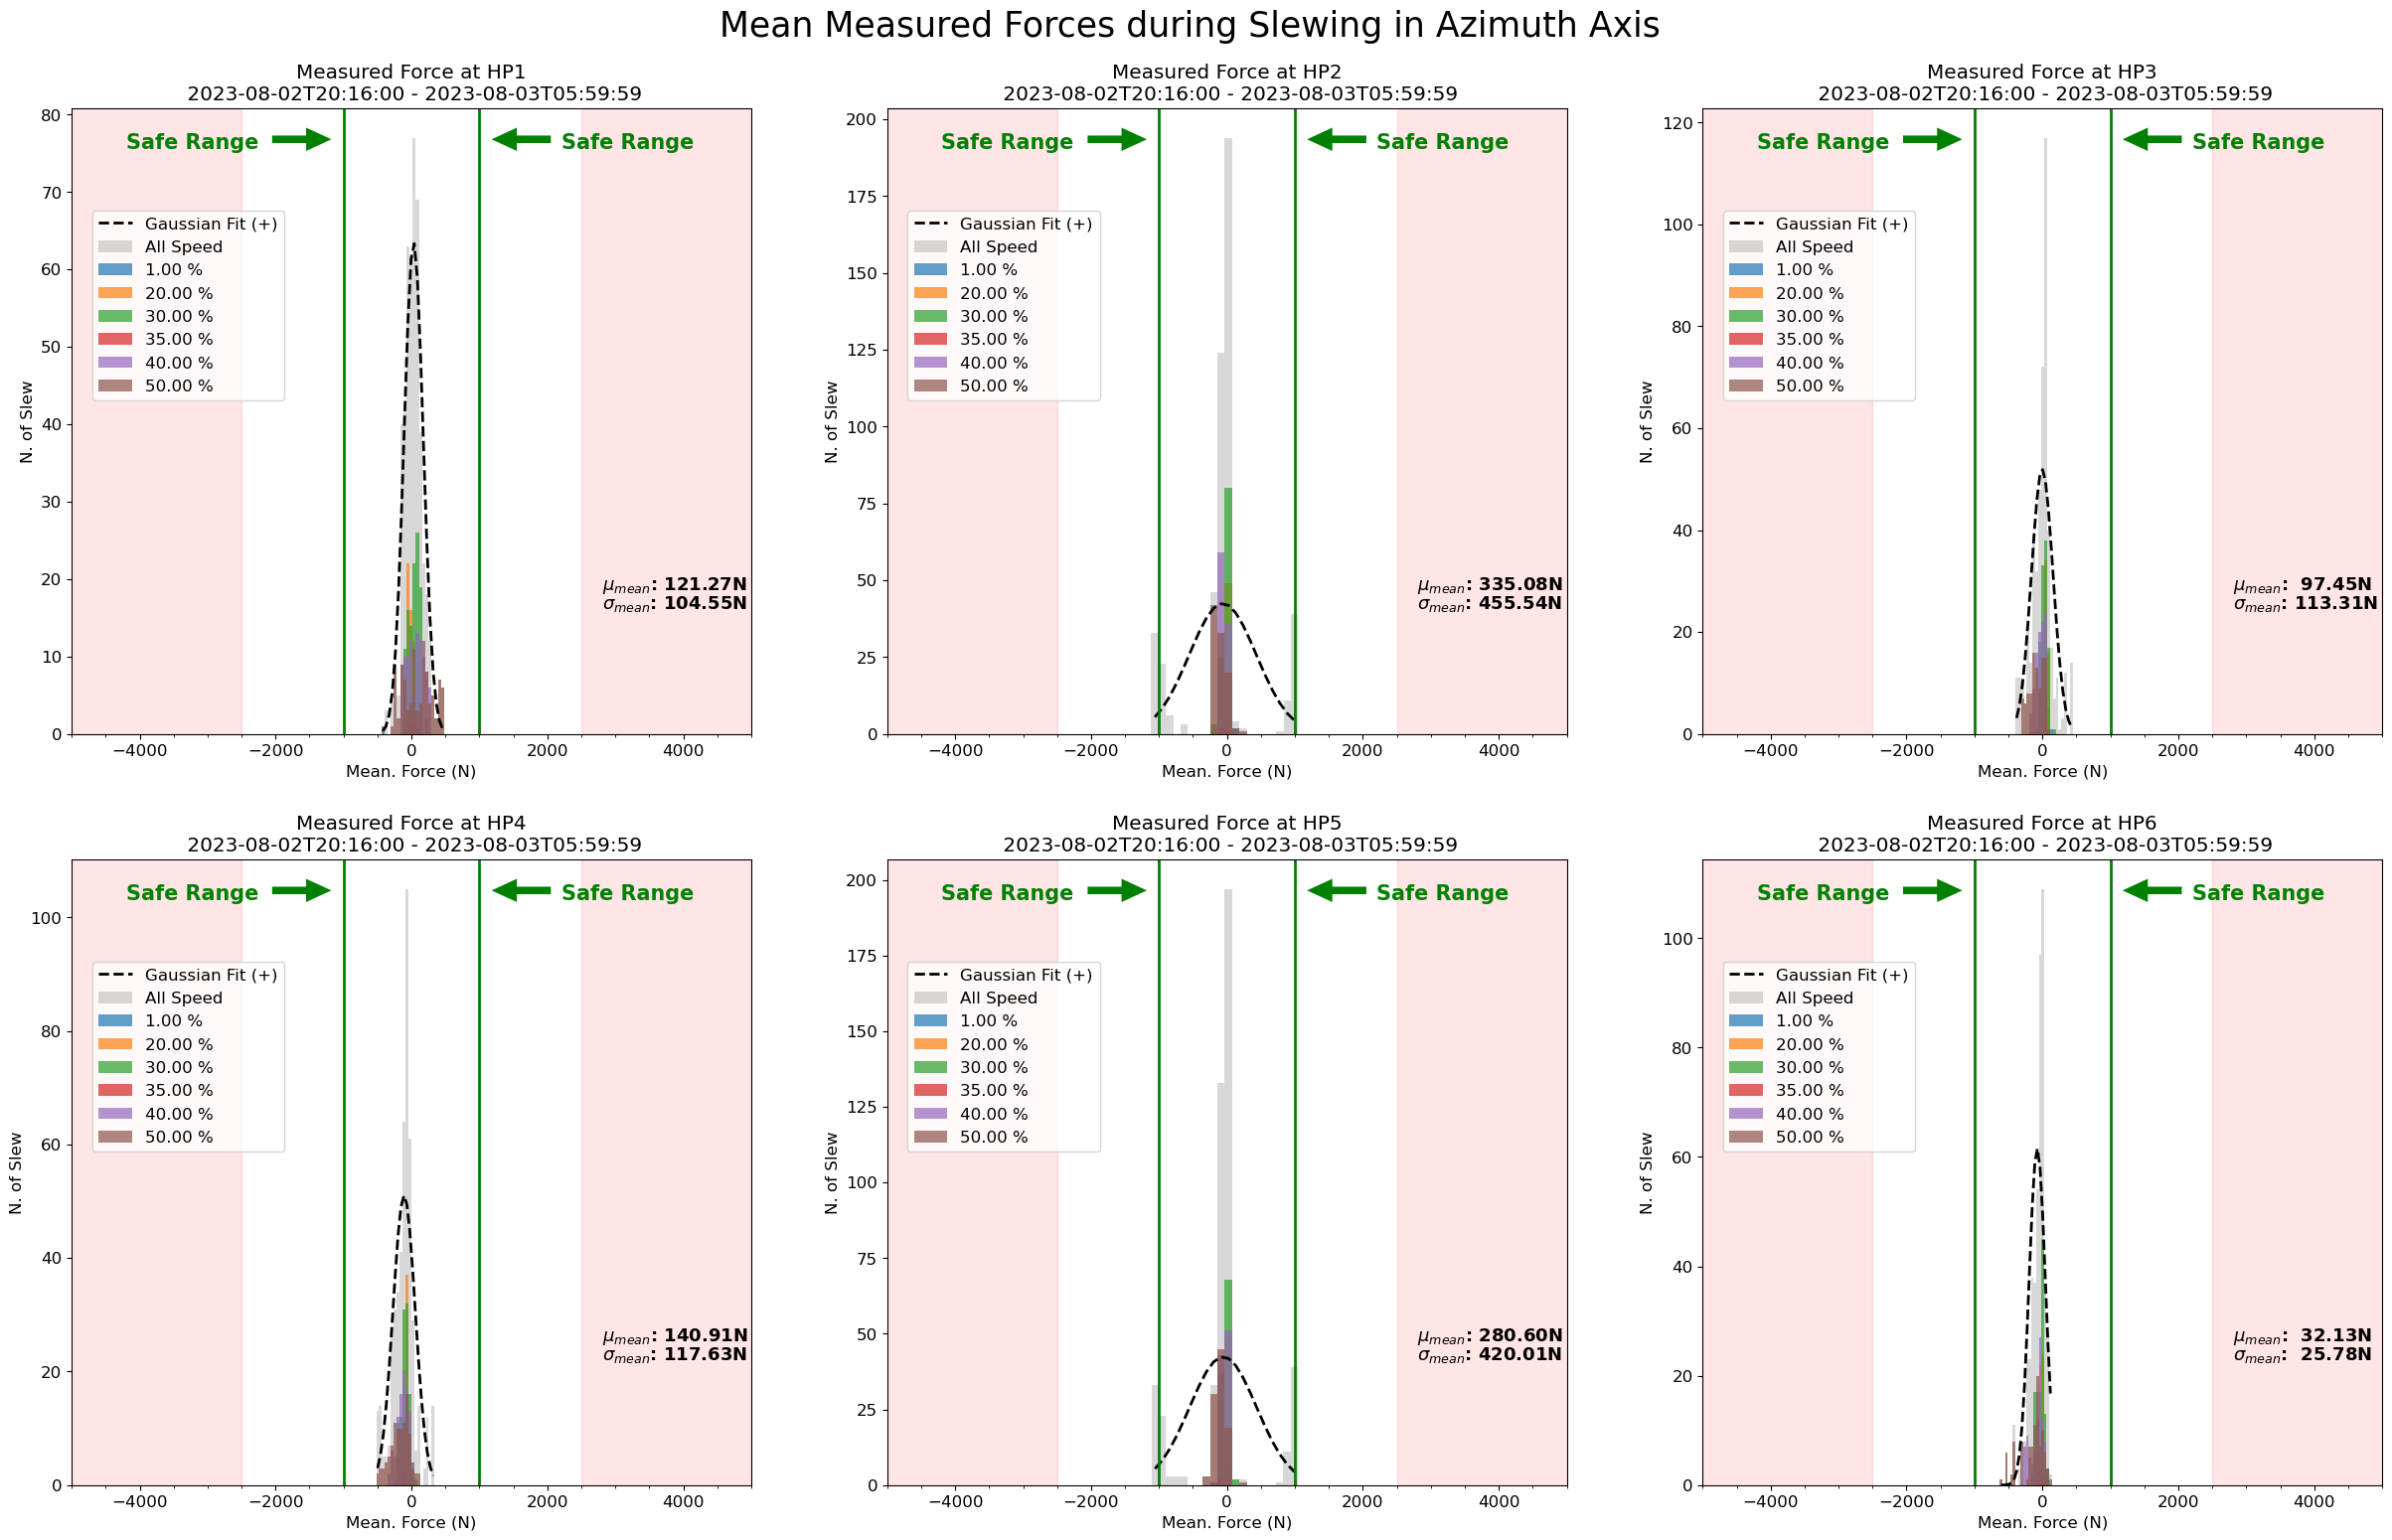

In [690]:
#Histograms of Mean Measured Forces for slewing in Elevation

fig,axs = plt.subplots(2,3, figsize=(30,18))
for hp_index in range(number_of_hardpoints):
    col_force = f"measuredForce{hp_index}"
    col_encoder = f"encoder{hp_index}"
    mean_hardpoint_data = []
    velocity_az = []
    handles=[]
    plt_col, plt_row = math.floor(hp_index/3), (hp_index % 3) 
    unit = 'N'
    axs[plt_col,plt_row].set_title(f"Measured Force at HP{hp_index+1}\n"
             f" {az.index[0].isoformat(timespec='seconds')[:-6]} -"
             f" {az.index[-1].isoformat(timespec='seconds')[:-6]}")
    axs[plt_col,plt_row].set_xlabel('Mean. Force (N)')
    axs[plt_col,plt_row].set_ylabel('N. of Slew')
    axs[plt_col,plt_row].axvspan(-5000, -2500, color='r',alpha=0.1)
    axs[plt_col,plt_row].axvspan(2500, 5000, color='r',alpha=0.1)
      
    #Velocity and mean HP measured forces  
    for i in range(len(slew_start_select)):
        pick_slew=hardpoint_data[(hardpoint_data["timestamp"]>= slew_start_select[i])&(hardpoint_data["timestamp"]<= slew_end_select[i])] 
        
        if len(pick_slew) > 1: 
            pick_az=az[(az["timestamp"]>= slew_start_select[i])&(az["timestamp"]<= slew_end_select[i])]
            
            if len(pick_az) > 1: 
                velocity_az.append(max(abs(pick_az["actualVelocity"])))
                mean_hardpoint_data.append(np.mean(pick_slew[col_force]))       
        
                    
        
    #Draw Histogram
    n, bins, patches = axs[plt_col, plt_row].hist((mean_hardpoint_data), 20, alpha=0.0, color="white")

    bin_heights, bin_edges = np.histogram((mean_hardpoint_data), 20, density=1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mu, sigma = norm.fit(mean_hardpoint_data)
    gaussian_values = norm.pdf(bin_centers, mu, sigma)
    
    mean_hardpoint_data_up = [mean_hardpoint_data[i] for i in range(len(mean_hardpoint_data))\
                             if mean_hardpoint_data[i] >=0]
    
    mean_hardpoint_data_down = [mean_hardpoint_data[i] for i in range(len(mean_hardpoint_data))\
                             if mean_hardpoint_data[i] < 0]
    

    
    mu_up, sigma_up = norm.fit(mean_hardpoint_data_up)
    mu_down, sigma_down = norm.fit(mean_hardpoint_data_down)

    gaussian_values_up = norm.pdf(bin_centers, mu_up, sigma_up)
    gaussian_values_down = norm.pdf(bin_centers, mu_down, sigma_down)

    
    #axs[plt_col, plt_row].plot(bin_centers, gaussian_values*len(mean_hardpoint_data)*[bins[1]-bins[0]], 'r--', label='Gaussian Fit')
    axs[plt_col, plt_row].plot(bin_centers, gaussian_values*len(mean_hardpoint_data)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (+)', linewidth=2)
    #axs[plt_col, plt_row].plot(bin_centers, gaussian_values_down*len(mean_hardpoint_data_down)*[bins[1]-bins[0]], 'k--', label='Gaussian Fit (-)', linewidth=2)
    n, bins, patches = axs[plt_col, plt_row].hist((mean_hardpoint_data), 20, alpha=0.3, color="gray", label="All Speed")

    
    axs[plt_col,plt_row].axvline(1000,color='green',linewidth=2)
    axs[plt_col,plt_row].axvline(-1000,color='green',linewidth=2)
    axs[plt_col,plt_row].text(0.08, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold", fontsize=15)
    axs[plt_col,plt_row].text(0.72, 0.935, 'Safe Range', transform=axs[plt_col,plt_row].transAxes, color='g', weight="bold",fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.900, 'Elevation', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)
    #axs[plt_col,plt_row].text(0.02, 0.850, 'vs. F$_{HP}$', transform=axs[plt_col,plt_row].transAxes, color='k', weight="bold", fontsize=15)

    #mark different velocities
        
    for i_vel_select in range(1, len(slew_speed_Az)):
        vel_hp_data = [mean_hardpoint_data[i] for i in range(len(mean_hardpoint_data))\
                       if velocity_az[i] >= slew_speed_Az[i_vel_select-1] and \
                       velocity_az[i] < slew_speed_Az[i_vel_select]]
        
        if len(vel_hp_data) > 0:                 
            axs[plt_col, plt_row].hist((vel_hp_data), bins=bins, alpha=0.7, label="{:.2f}".format(100.0*slew_speed_Az[i_vel_select-1]/Az_velocity_max)+" %")

    
    #axs[plt_col, plt_row].axvspan(1000, -1000, color="lightgreen", alpha=0.05)

    axs[plt_col,plt_row].set_xlim(-5000,5000)
    arrow_style = {"head_width":0.02, "head_length":0.02, "color":"g", "linewidth":5, "transform":axs[plt_col,plt_row].transAxes}
    axs[plt_col,plt_row].arrow(x=0.3, y=0.95, dx=0.05, dy=0, **arrow_style)
    axs[plt_col,plt_row].arrow(x=0.7, y=0.95, dx=-0.05, dy=0, **arrow_style)

    
    #axs[plt_col,plt_row].text(0.02,0.2, "${\sigma}_{mean}$: "+"{:6.2f}".format(sigma_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    #axs[plt_col,plt_row].text(0.02,0.23, "${\mu}_{mean}$: "+"{:6.2f}".format(mu_down)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.2, "${\sigma}_{mean}$: "+"{:6.2f}".format(sigma_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    axs[plt_col,plt_row].text(0.78,0.23, "${\mu}_{mean}$: "+"{:6.2f}".format(mu_up)+"N", transform=axs[plt_col,plt_row].transAxes, weight="bold", fontsize=13)
    #axs[plt_col,plt_row].text(0.7,0.85, "${std.dev}_{mean}$:"+"{:6.2f}".format(np.std(np.absolute(mean_hardpoint_data)))+" N", transform=axs[plt_col,plt_row].transAxes, weight="bold")
    axs[plt_col,plt_row].yaxis.get_major_locator().set_params(integer=True)
    
    #axs[0, 2].legend(bbox_to_anchor=(1.4,1))
    axs[plt_col,plt_row].legend(bbox_to_anchor=(0.325,0.85))
    axs[plt_col,plt_row].xaxis.set_minor_locator(MultipleLocator(500))


os.makedirs("plots/plots"+f"_{dayObs}", exist_ok=True)
fig.suptitle("Mean Measured Forces during Slewing in Azimuth Axis",fontsize=25, y=0.935)
fig.savefig("plots/plots"+f"_{dayObs}"+"/Measured_Force_data_all_az_mean"+f"_{az.index[0].isoformat(timespec='seconds')[:-6]}.png")
fig.show()

#timestamp = hardpoint_data.index[0].isoformat().split('.')[0].replace('-','').replace(':','')
